In [1]:
import os
import torch
from scipy import signal
import heartpy.filtering
import numpy as np
import sys
import wfdb
from ecg_qc.ecg_qc import EcgQc
import pandas as pd
import logging
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:

database_path = "mit-bih-normal-sinus-rhythm-database-1.0.0/" # Path to the MIT-BIH Normal Sinus Rhythm Database
data_files = [database_path + file for file in os.listdir(database_path) if ".dat" in file]
save_path = '/save_path/' # Path to save the processed dataset


In [3]:
names_samples = []
fs = 128
win = 5
fs_new = 128
signal_quality = []
part = 1

In [4]:
## Loop ecg.bin files
for participant, file in enumerate(data_files):
    counter = 0

    if participant==part:

        logging.critical("Participant: " + str(participant) + "/" + str(len(data_files)))

        data = wfdb.rdsamp(data_files[part][:-4])[0][:,0]
        ECG_SIGNAL = torch.Tensor(data)  # Final numpy array containing full days record

        # windows of 10 s
        pbar = tqdm(total=data.size/fs)
        for i in range(0, data.size, fs):
            min_limit = i
            max_limit = i + win * fs

            if (max_limit <= data.size):

                # Save path
                counter = counter + 1
                name_sample = "{}_{:012d}".format(participant, counter)
                names_samples.append(name_sample)

                window_complete = ECG_SIGNAL[min_limit:max_limit]

                # Median Filter
                med = signal.medfilt(window_complete, 3)

                # Bandpass Filter
                filt = heartpy.filtering.filter_signal(med, [0.5, 30], fs, order=2,
                                                        filtertype='bandpass')

                # Signal Quality
                signal_quality_now = []
                win_intra = 1
                for k in range(win_intra * fs, window_complete.shape[0] + 1, win_intra * fs):
                    min_limit = k - win_intra * fs
                    max_limit = k
                    window_complete_intra = filt[min_limit:max_limit]
                    ecg_qc = EcgQc(model_file='xgb_9s.joblib', sampling_frequency=fs, normalized=False)
                    signal_quality_now.append(ecg_qc.get_signal_quality(window_complete_intra))

                signal_quality.append(np.mean(signal_quality_now))
                pbar.update(1)

CRITICAL:root:Participant: 3/18
  0%|          | 213/86336.0 [00:34<3:52:37,  6.17it/s]

KeyboardInterrupt: 

In [9]:
np.save(f'signal_quality_{part+1}.npy', np.array(signal_quality))

In [4]:
# Load signal_quality from a file named 'signal_quality_2.npy'
signal_quality_2_path = os.path.join(f'signal_quality_{part+1}.npy')
signal_quality = np.load(signal_quality_2_path)
print(signal_quality)

[1.  1.  1.  ... 0.4 0.6 0.6]


In [5]:
is_quality = signal_quality < 0.6
print(is_quality)

[False False False ...  True False False]


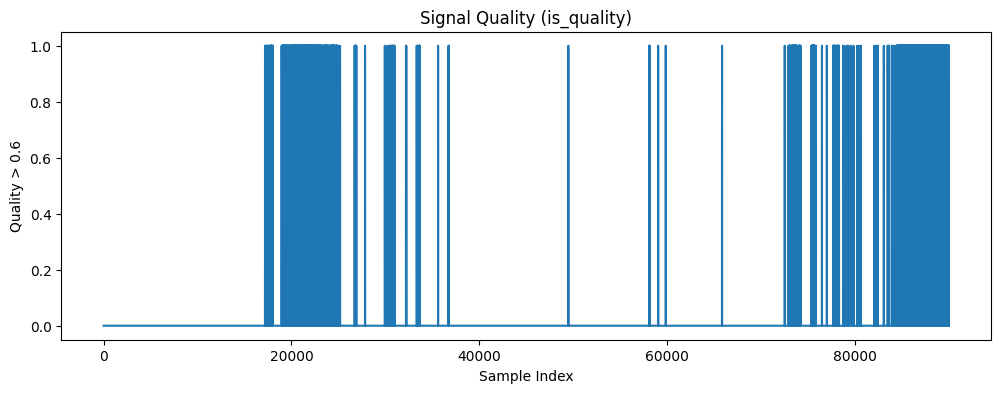

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(is_quality)
plt.title('Signal Quality (is_quality)')
plt.xlabel('Sample Index')
plt.ylabel('Quality > 0.6')
plt.show()

In [6]:
arteffects_intervals = []
min_limit = 0
max_limit = 0

for i,is_arteffect in enumerate(is_quality):

    if is_arteffect==True and (max_limit/fs) <=i:
        min_limit = i*fs
        max_limit = (i+5)*fs
        condition = True
        k = i
        while condition:
            k = k + 1
            if k<=len(is_quality)-1:
                if is_quality[k]==True:
                    max_limit = max_limit + fs
                else:
                    condition = False
            else:
                break
        arteffects_intervals.append((min_limit, max_limit))


In [7]:
data = wfdb.rdsamp(data_files[part][:-4])[0][:,0]
ECG_SIGNAL = torch.Tensor(wfdb.rdsamp(data_files[part][:-4])[0][:,0])

In [8]:
# Median Filter
ECG_SIGNAL = signal.medfilt(ECG_SIGNAL, 3)

# Bandpass Filter
ECG_SIGNAL = heartpy.filtering.filter_signal(ECG_SIGNAL, [0.5, 30], fs, order=2,
                                        filtertype='bandpass')


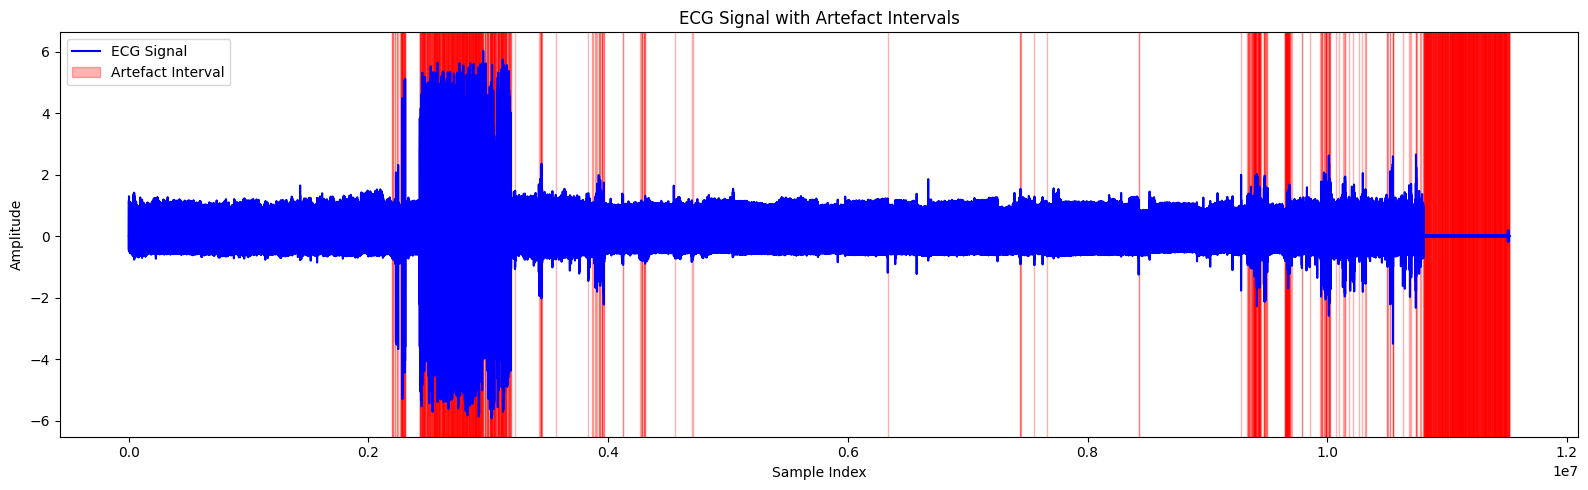

In [10]:
plt.figure(figsize=(16, 5))
plt.plot(ECG_SIGNAL, label='ECG Signal', color='blue')

for start, end in arteffects_intervals:
    plt.axvspan(start, end, color='red', alpha=0.3, label='Artefact Interval' if start == arteffects_intervals[0][0] else "")

plt.title('ECG Signal with Artefact Intervals')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

### Data Preparation for Model fitting

In [153]:
X = []
counter = 0
pbar_2 = tqdm(total=data.size/fs)
for i in range(0, data.size, fs):
    min_limit = i
    max_limit = i + win * fs

    if (max_limit <= data.size) and not(is_quality[counter]):
        window = ECG_SIGNAL[min_limit:max_limit]
        X.append(window)
        counter = counter + 1
    pbar_2.update(1)
X = np.array(X)

100%|██████████| 90000/90000.0 [00:00<00:00, 96279.69it/s] 

In [154]:
print("X shape:", X.shape)

X shape: (17181, 640)


### Modeling

In [12]:
from sklearn.mixture import GaussianMixture

In [249]:
n_components = 6
gmm_model = GaussianMixture(n_components=n_components, 
                            covariance_type='full', 
                            random_state=42)

In [13]:
import joblib

In [250]:
print(f"Training Gaussian Mixture Model with {n_components} components...")


gmm_model.fit(X)

Training Gaussian Mixture Model with 6 components...


KeyboardInterrupt: 

In [16]:
# Save the model
joblib.dump(gmm_model, "gmm_model.pkl")

NameError: name 'gmm_model' is not defined

In [251]:
# Load the model later
gmm_model = joblib.load("gmm_model.pkl")

In [15]:
log_likelihoods = gmm_model.score_samples(X)

In [ ]:
print(f"\nExample log-likelihoods for a few 'normal' test samples:")
print(log_likelihoods[:5])


Example log-likelihoods for a few 'normal' test samples:
[1615.02789478 1551.95429465 1581.88124646 1586.77806938 1620.28258485]


In [17]:
log_likelihoods.shape

(17181,)

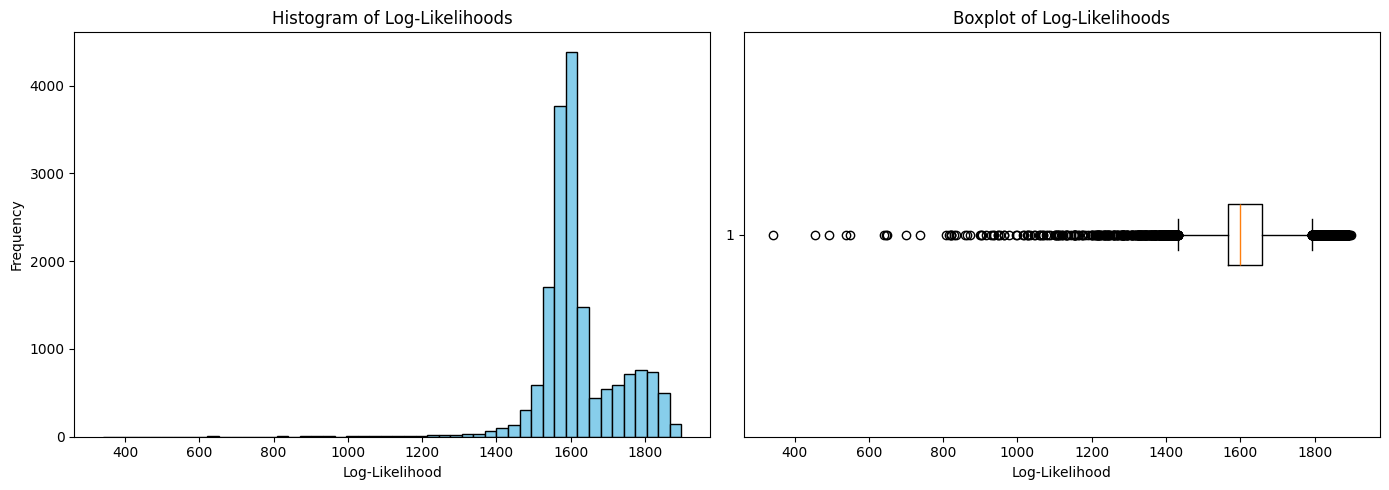

In [18]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(log_likelihoods, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Log-Likelihoods')
plt.xlabel('Log-Likelihood')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(log_likelihoods, vert=False)
plt.title('Boxplot of Log-Likelihoods')
plt.xlabel('Log-Likelihood')

plt.tight_layout()
plt.show()

### Arrhythmia-database ------------------------------------------------------

In [18]:
path = 'mit-bih-arrhythmia-database-1.0.0/' # Path to the MIT-BIH Arrhythmia Database
save_path = '/save_path/' # Path to save the processed dataset
valid_lead = ['MLII'] #, 'II', 'I', 'MLI', 'V5'

with open(os.path.join(path, 'RECORDS'), 'r') as fin:
    all_record_name = fin.read().strip().split('\n')


### Experiment with last record

In [19]:
for record_name in all_record_name:
    try:
        tmp_ann_res = wfdb.rdann(path + '/' + record_name, 'atr').__dict__
        tmp_data_res = wfdb.rdsamp(path + '/' + record_name)
    except:
        print('read data failed')
        continue

In [20]:
print(tmp_ann_res)

{'record_name': '234', 'extension': 'atr', 'sample': array([    52,    135,    366, ..., 649292, 649536, 649772], shape=(2764,)), 'symbol': ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

In [21]:
tmp_data_res

(array([[-0.08 ,  0.135],
        [-0.08 ,  0.135],
        [-0.08 ,  0.135],
        ...,
        [-0.395,  0.075],
        [-0.38 ,  0.08 ],
        [ 0.   ,  0.   ]], shape=(650000, 2)),
 {'fs': 360,
  'sig_len': 650000,
  'n_sig': 2,
  'base_date': None,
  'base_time': None,
  'units': ['mV', 'mV'],
  'sig_name': ['MLII', 'V1'],
  'comments': ['56 F 1971 3655 x2', 'None', 'The PVCs are uniform.']})

In [242]:
# Data
tmp_data = tmp_data_res[0][:, 0]

In [300]:
med_tmp = signal.medfilt(tmp_data, 3)
filt_tmp = heartpy.filtering.filter_signal(med_tmp, [0.5, 30], 360, order=2,
                                    filtertype='bandpass')
signal_new_tmp = signal.resample(filt_tmp, 128 * (tmp_data.shape[0]//360))

In [303]:
# Positions
idx_list = list(tmp_ann_res['sample'])

In [304]:
pd.DataFrame(tmp_ann_res['symbol'])[0].unique()

array(['+', 'N', '~', 'J', 'V'], dtype=object)

In [305]:
#Labels
label_beat_list = tmp_ann_res['symbol']
replacements = {'N': '(N', '/': '(N', '.': '(N', '[': '(N', '!': '(N', ']': '(N', 'x': '(N', '(': '(N', ')': '(N', 'p': '(N', 't': '(N', 'u': '(N', '`': '(N',
                '\'': '(N', '^': '(N', '|': '(N', '~': '(N', '+': '(N', 's': '(N', 'T': '(N', '*': '(N', 'D': '(N', '=': '(N', '"': '(N', '@': '(N'}  # Define replacements
label_beat_list = [replacements.get(x, x) for x in label_beat_list]

label_rhythm = tmp_ann_res['aux_note']
replacements_r = {'(P\x00': '(N'}  # Define replacements
label_rhythm = [replacements_r.get(x, x) for x in label_rhythm]

In [306]:
pd.DataFrame(label_beat_list)[0].unique()

array(['(N', 'J', 'V'], dtype=object)

In [307]:
X_test = []
counter = 0
for i in range(0, signal_new_tmp.size, fs):
    min_limit = i
    max_limit = i + win * fs

    if (max_limit <= signal_new_tmp.size):
        window = signal_new_tmp[min_limit:max_limit]
        X_test.append(window)
        counter = counter + 1
X_test = np.array(X_test)

In [308]:
X_test.shape

(1801, 640)

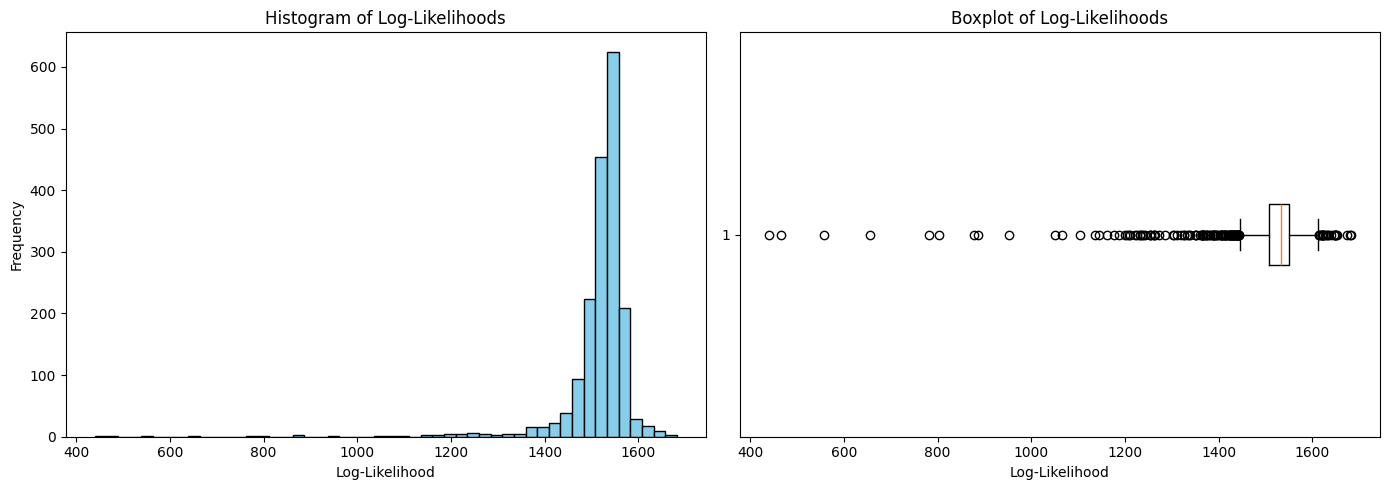

In [384]:
log_likelihoods_test = gmm_model.score_samples(X_test)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(log_likelihoods_test, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Log-Likelihoods')
plt.xlabel('Log-Likelihood')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(log_likelihoods_test, vert=False)
plt.title('Boxplot of Log-Likelihoods')
plt.xlabel('Log-Likelihood')

plt.tight_layout()
plt.show()

In [437]:
is_anomaly_window = log_likelihoods_test < 1426
print(np.sum(is_anomaly_window)/len(is_anomaly_window))
anomaly_window = X_test[is_anomaly_window]
anomaly_window.shape

0.05108273181565797


(92, 640)

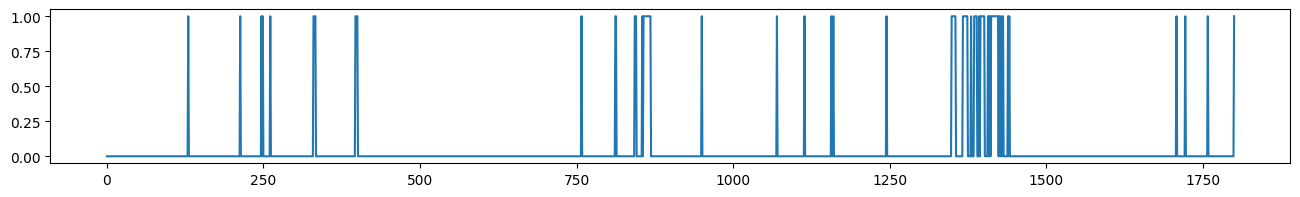

In [438]:
plt.figure(figsize=(16, 2))
plt.plot(is_anomaly_window)

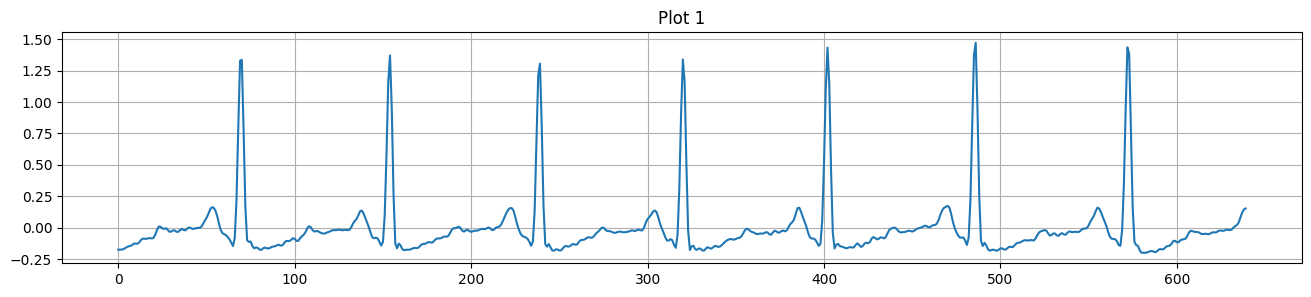

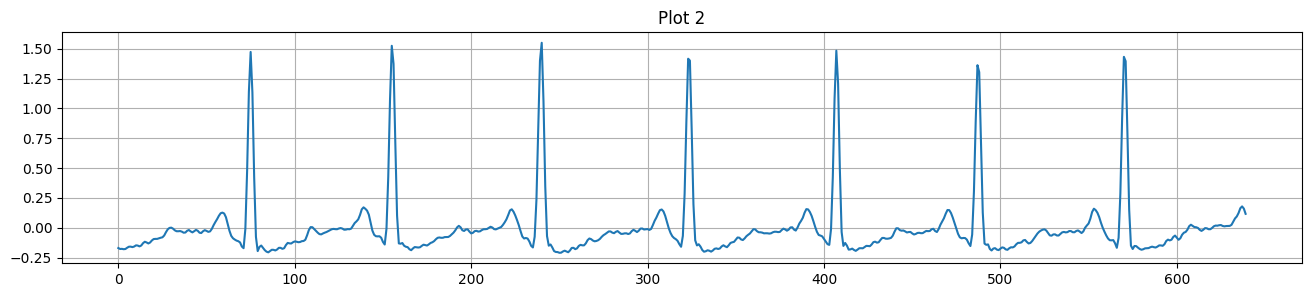

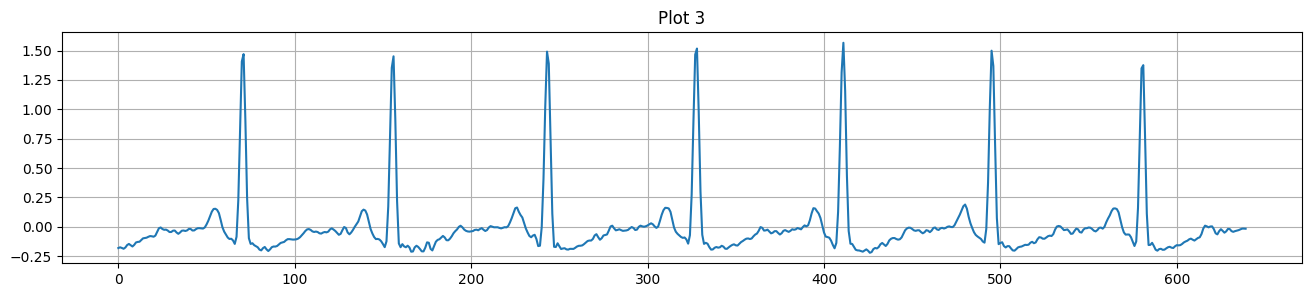

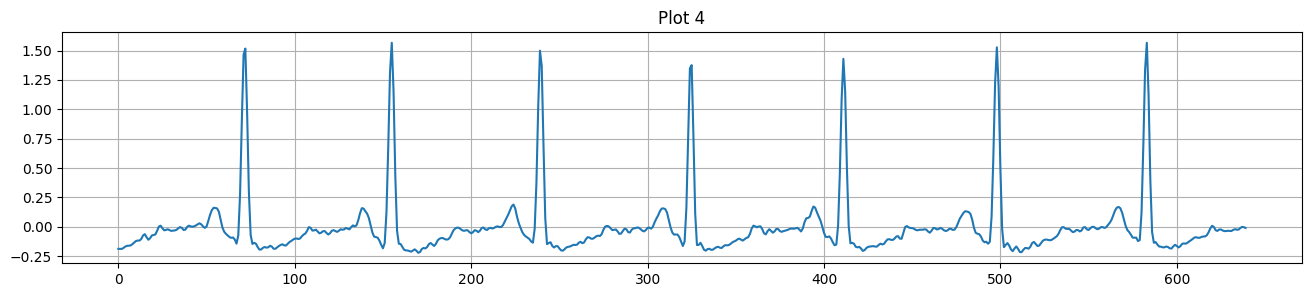

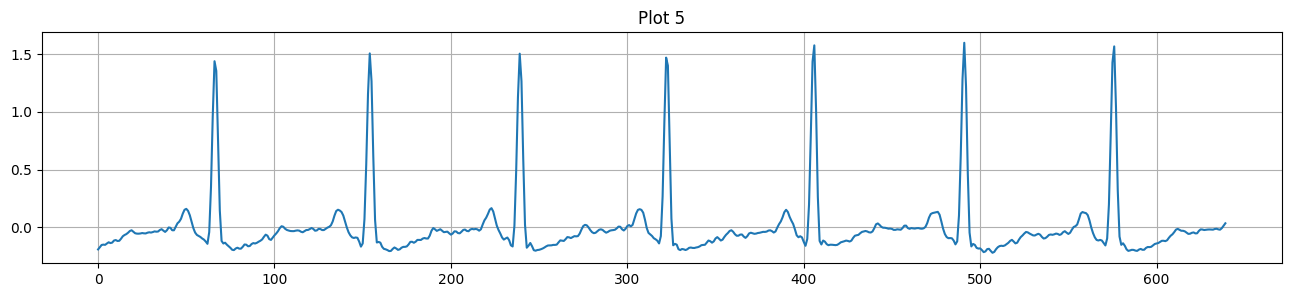

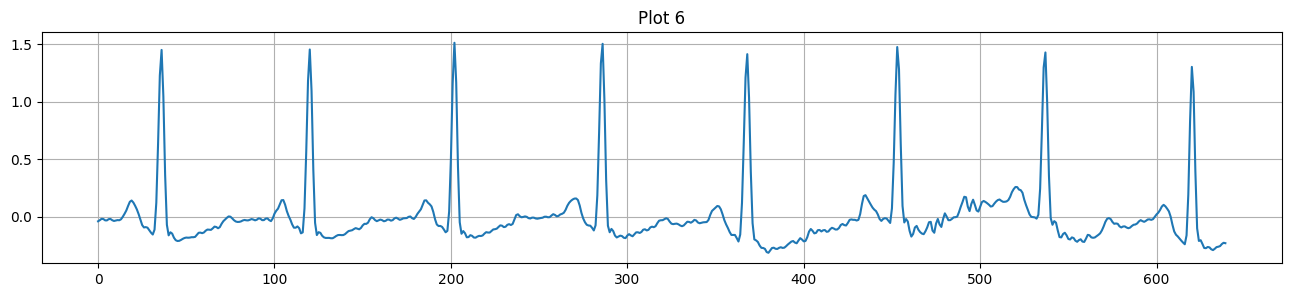

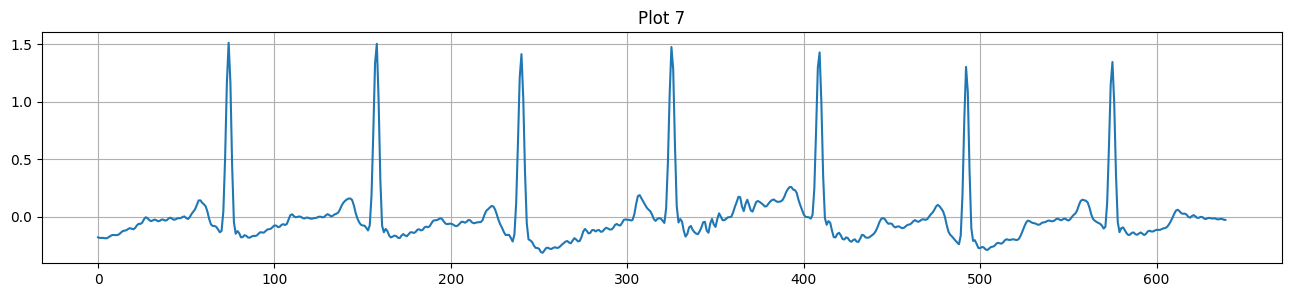

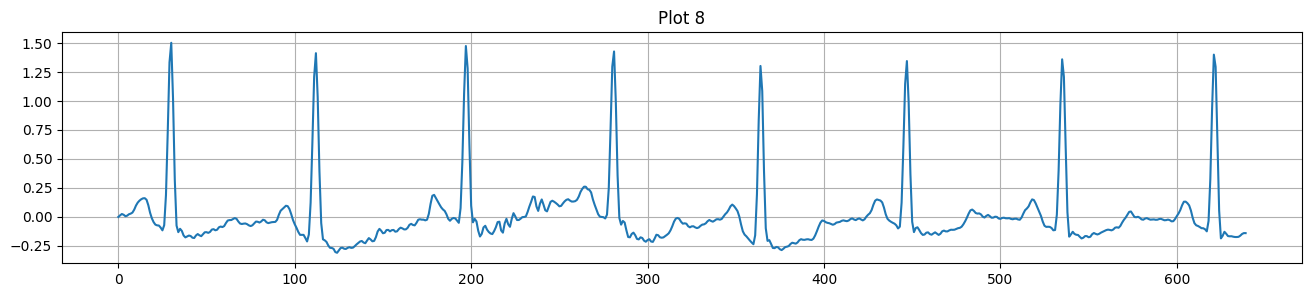

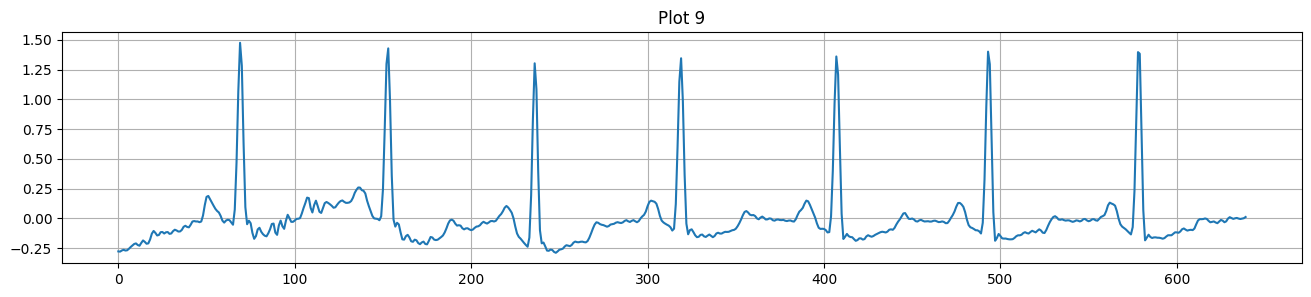

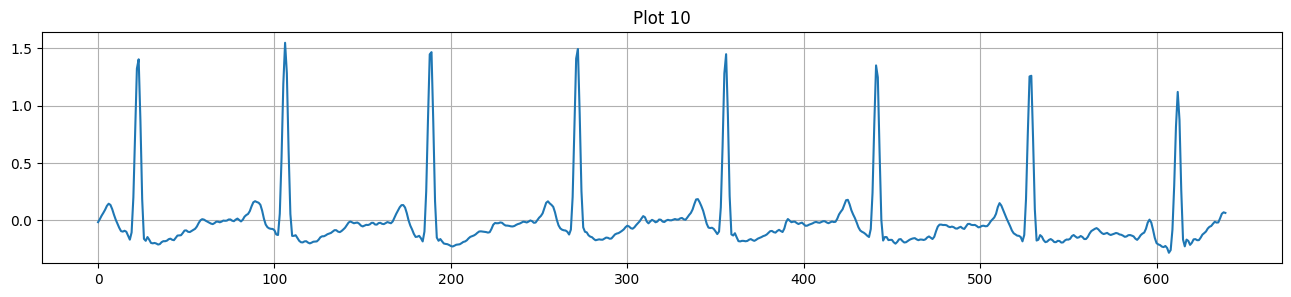

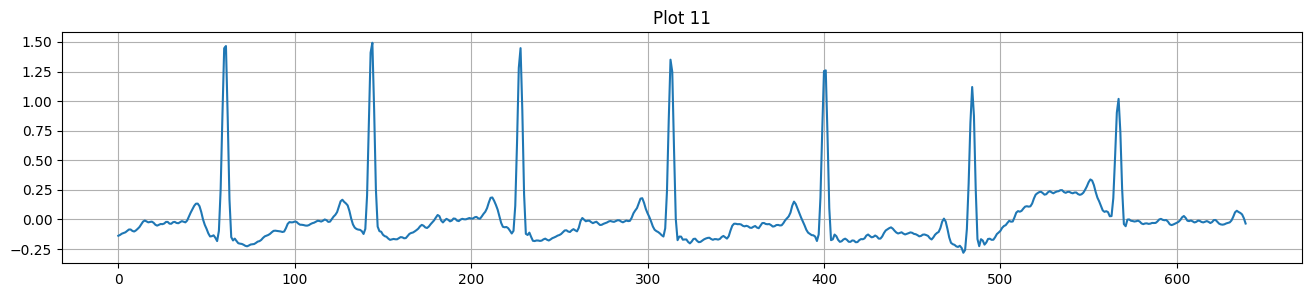

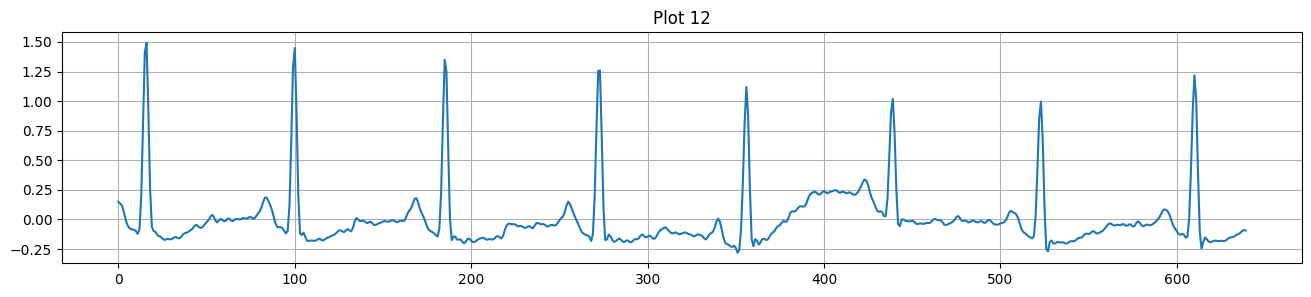

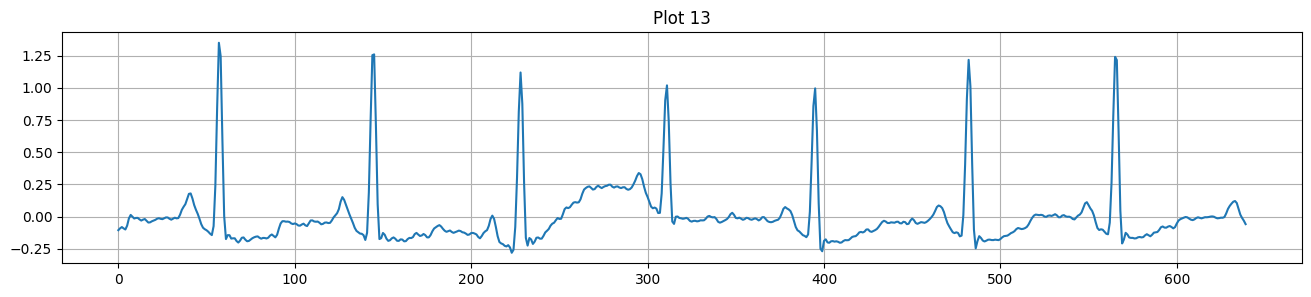

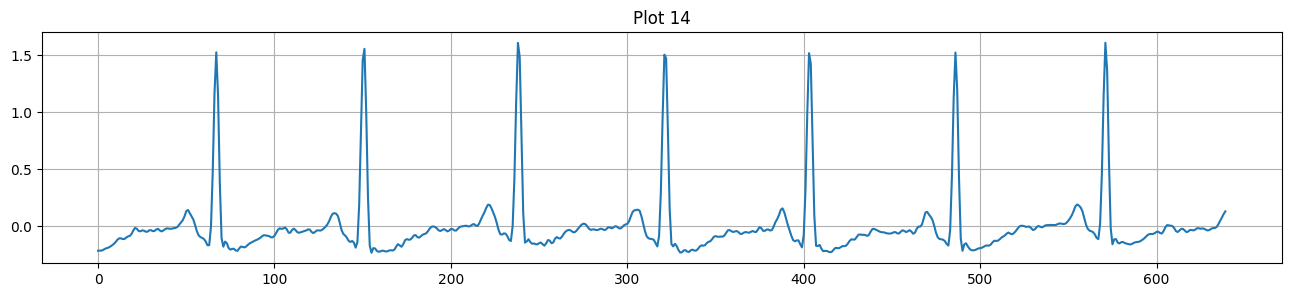

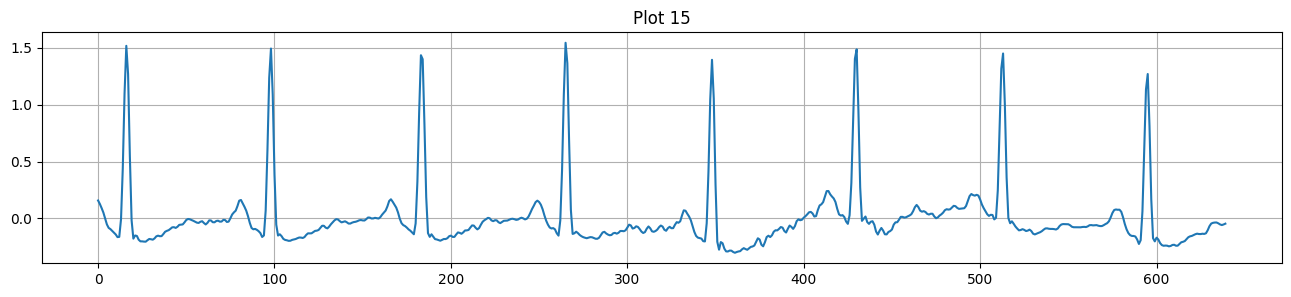

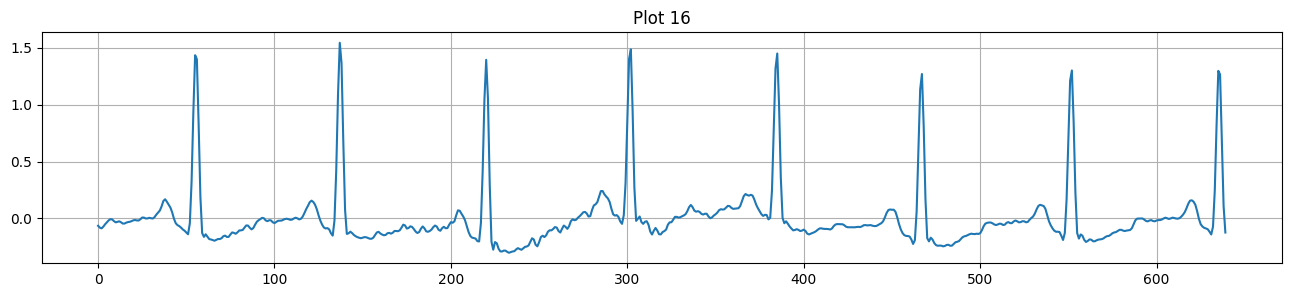

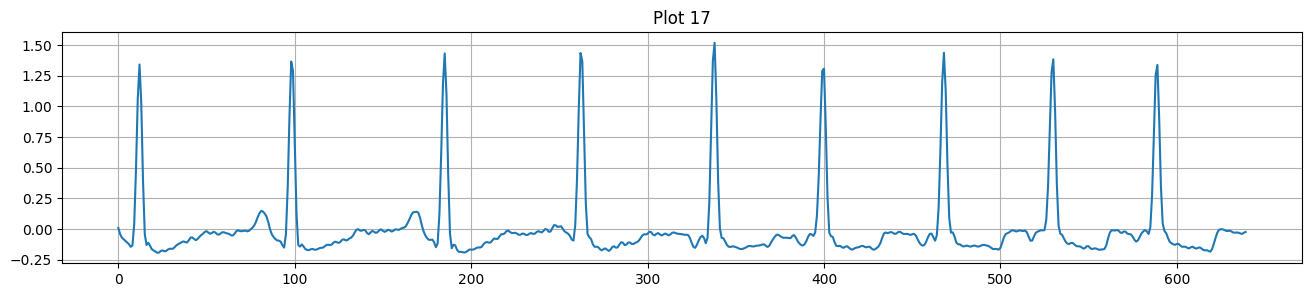

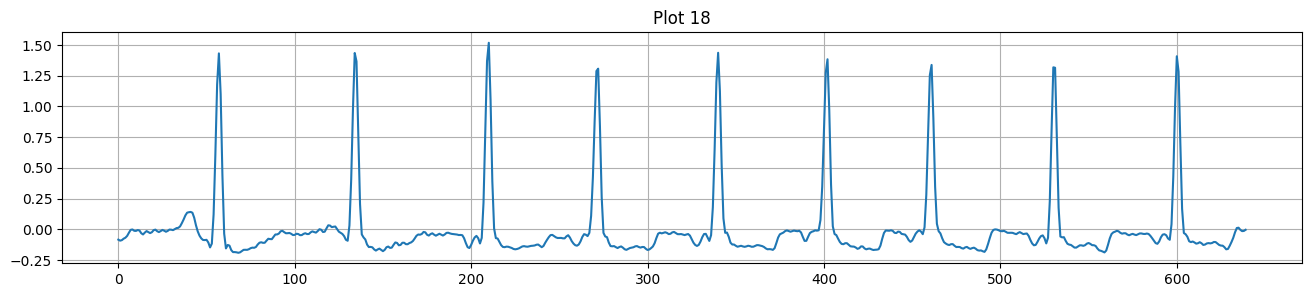

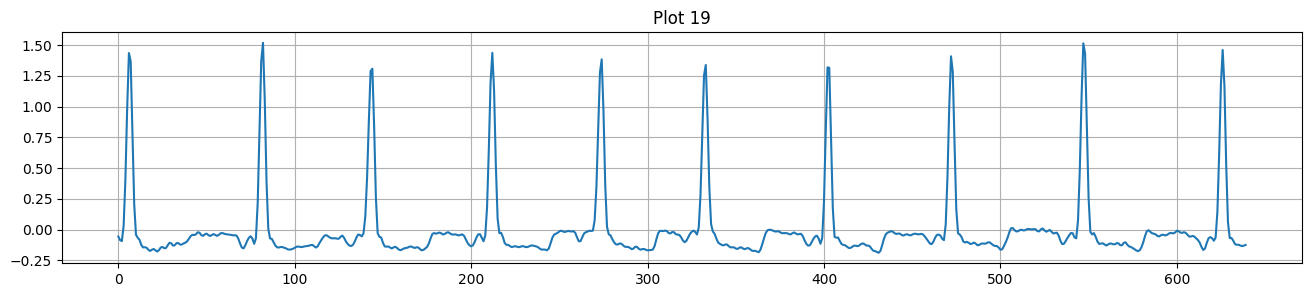

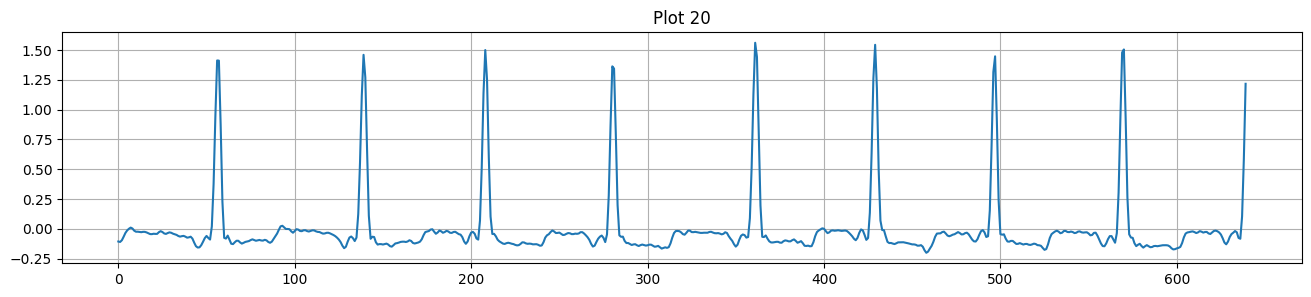

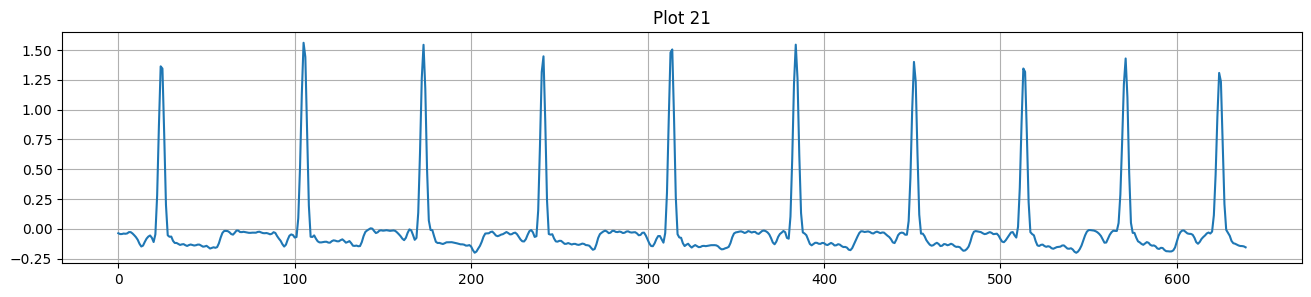

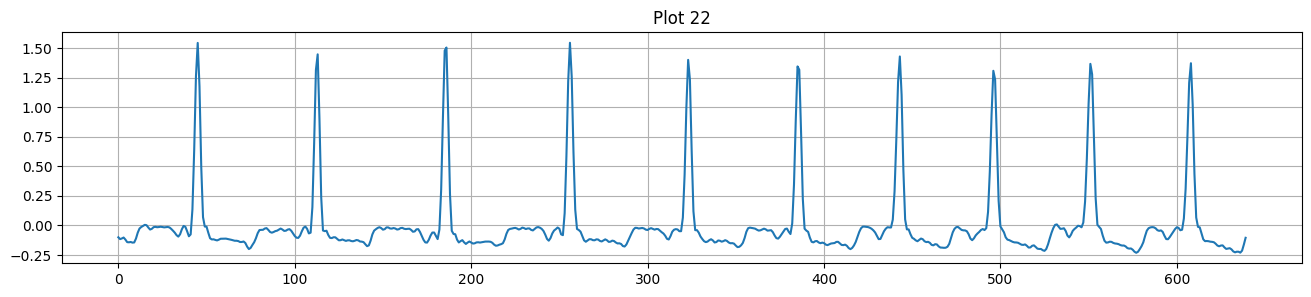

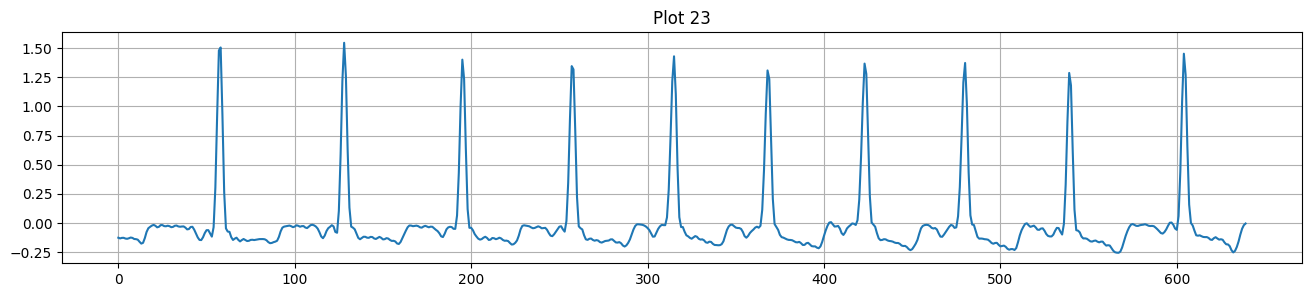

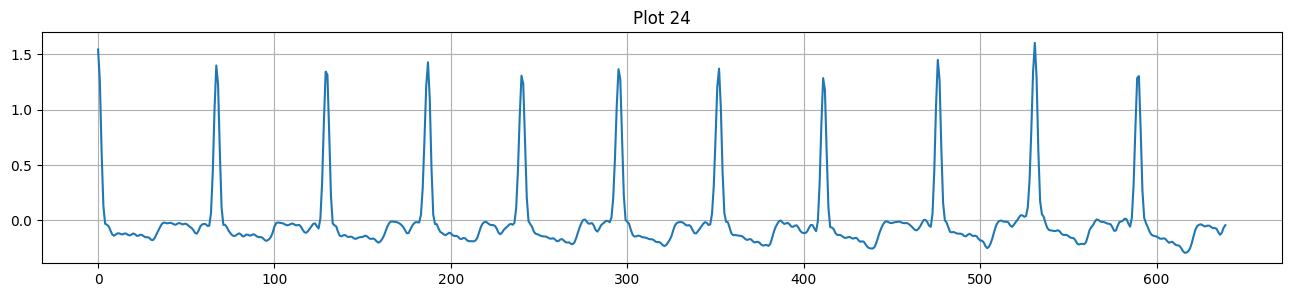

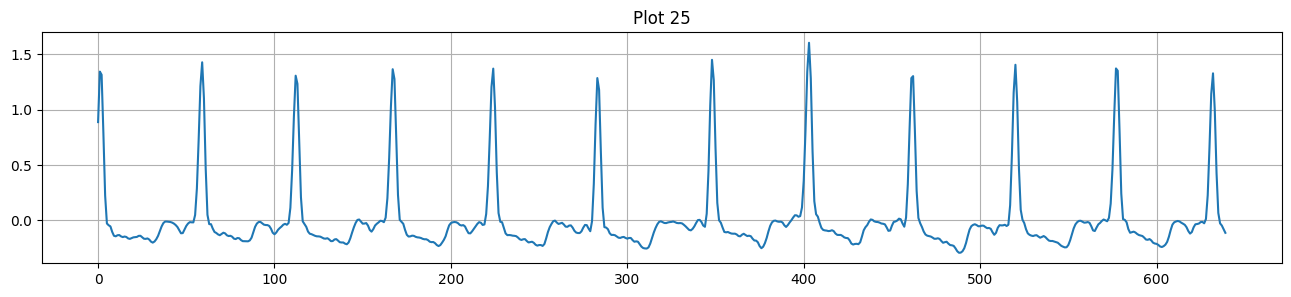

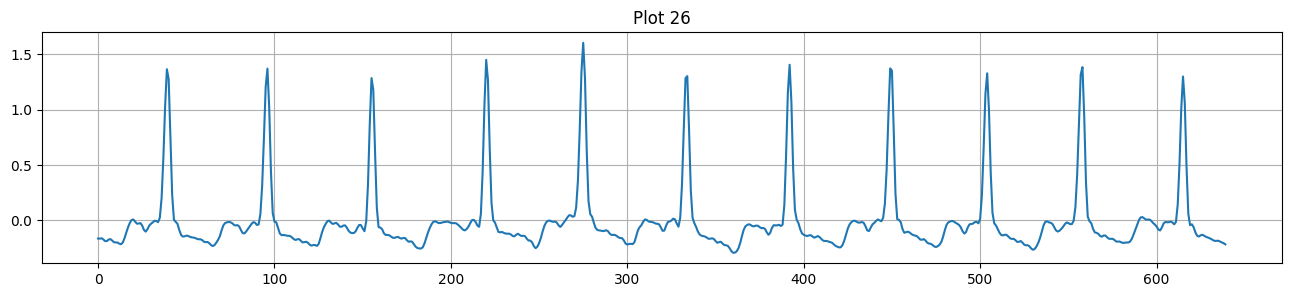

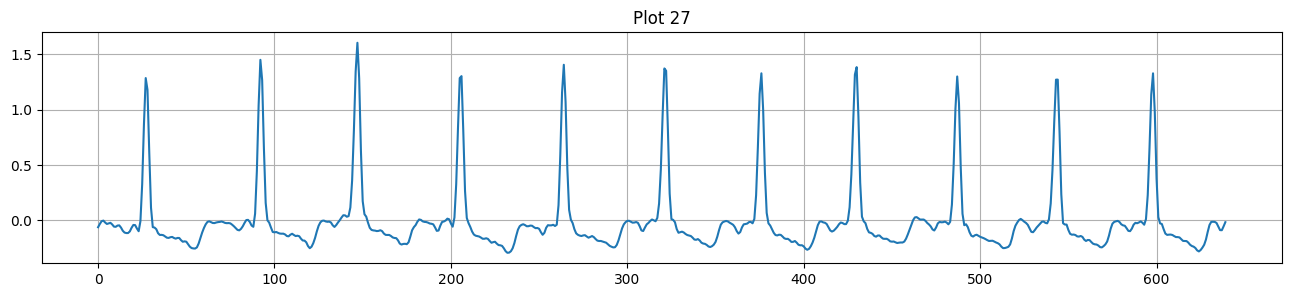

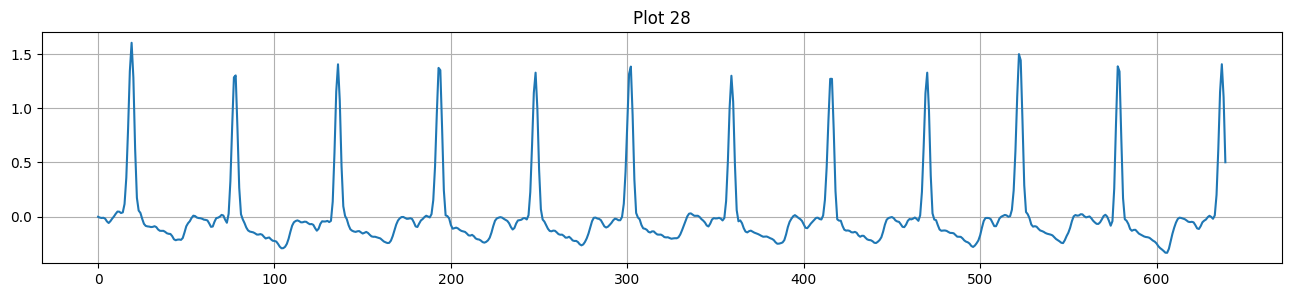

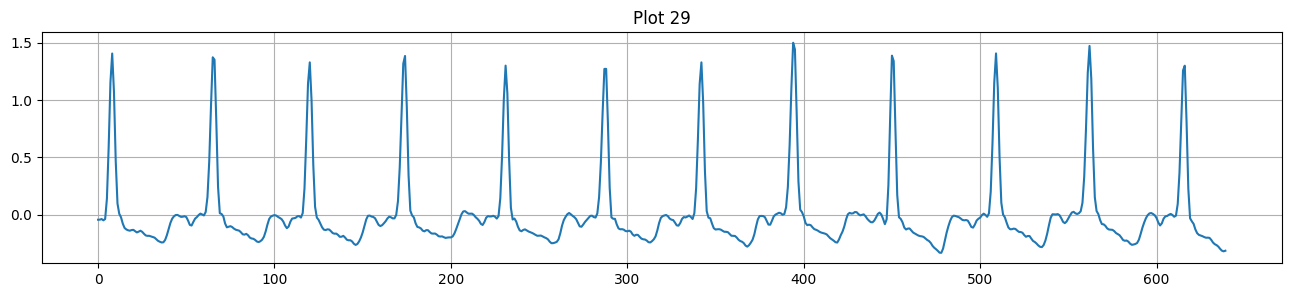

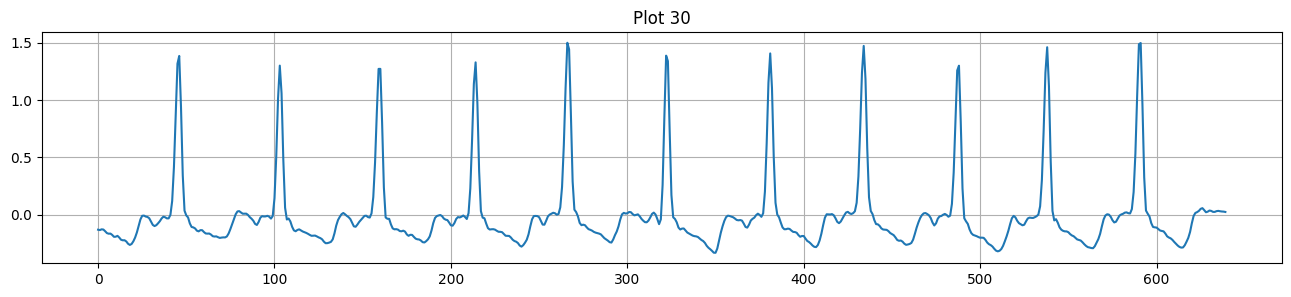

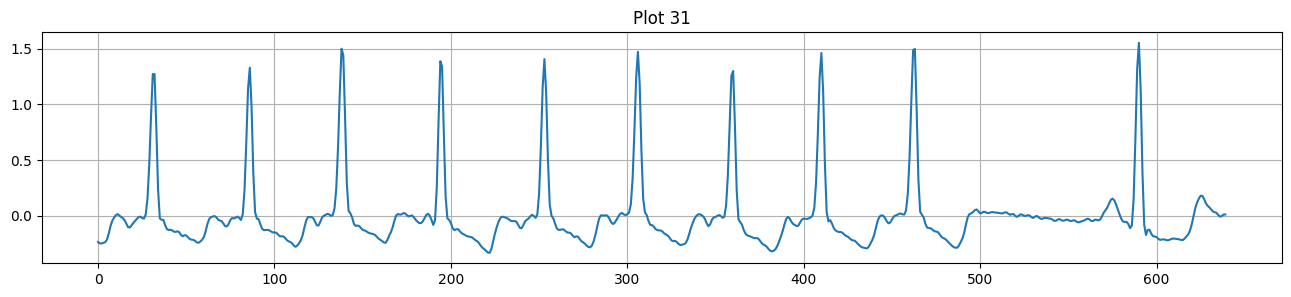

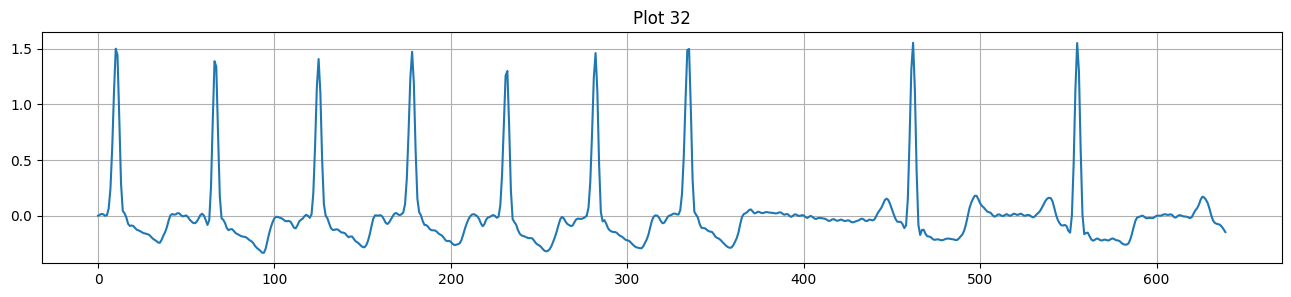

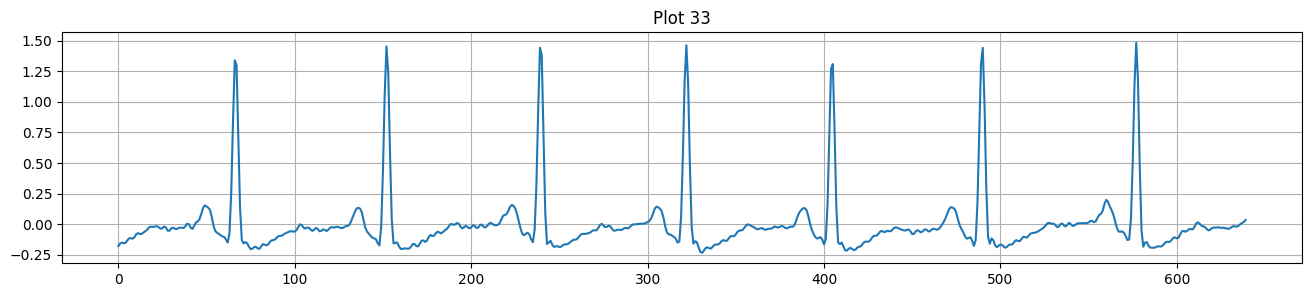

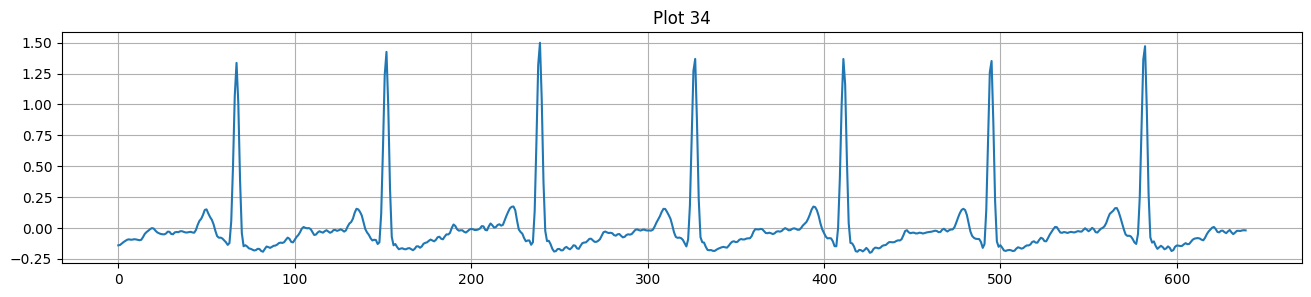

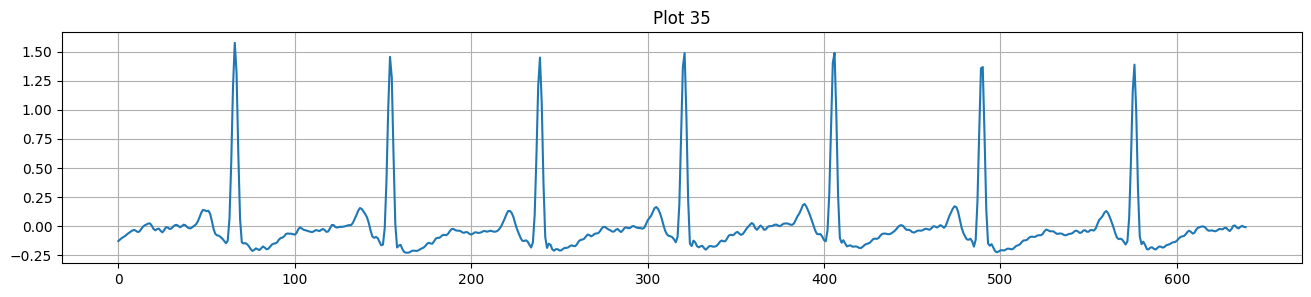

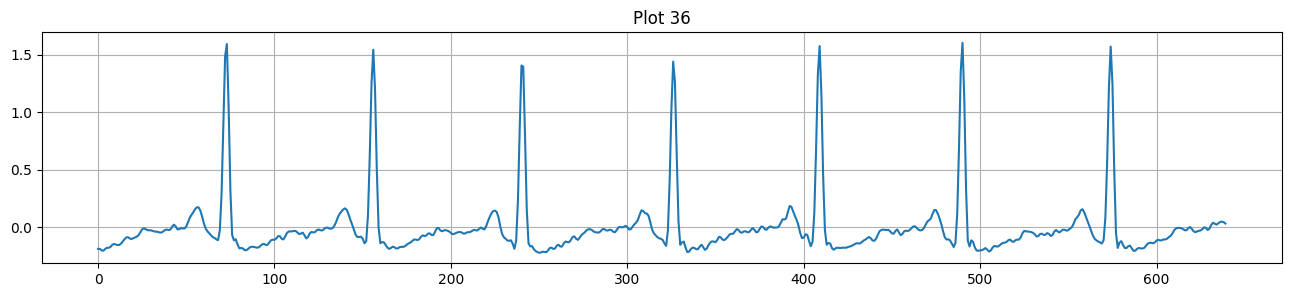

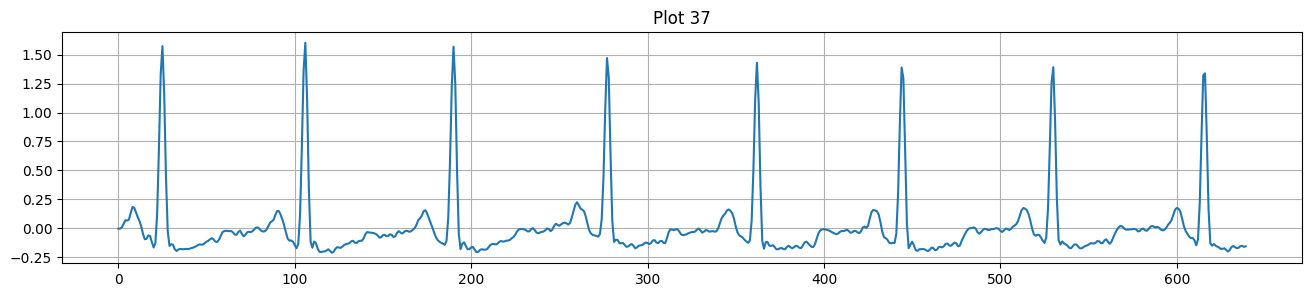

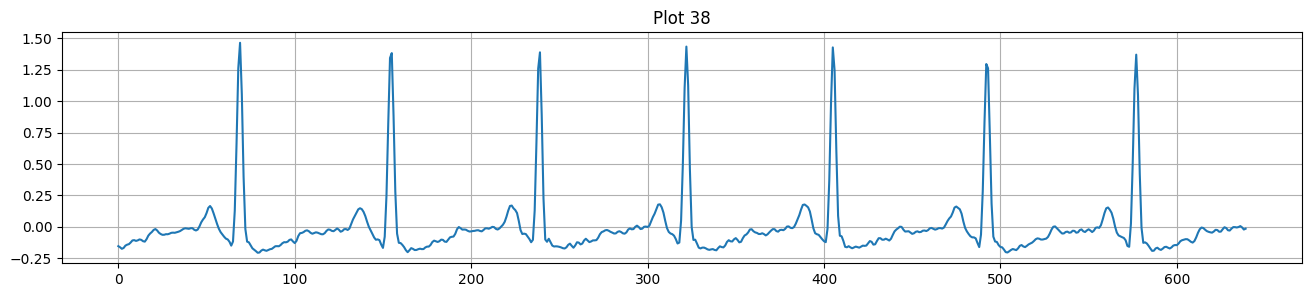

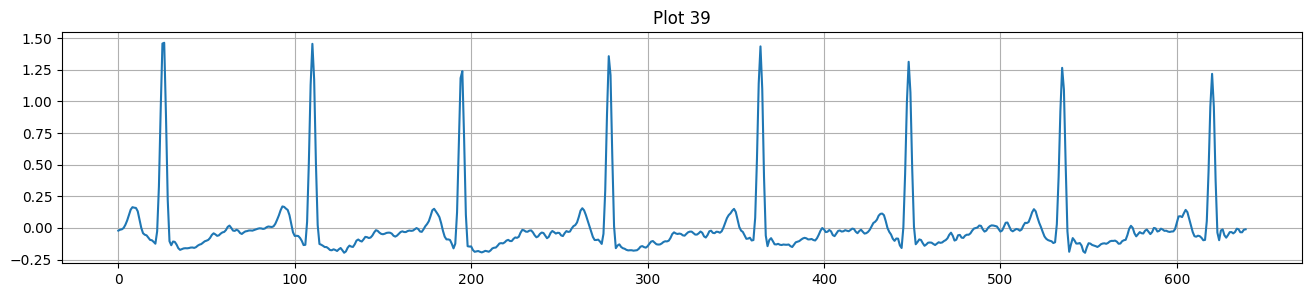

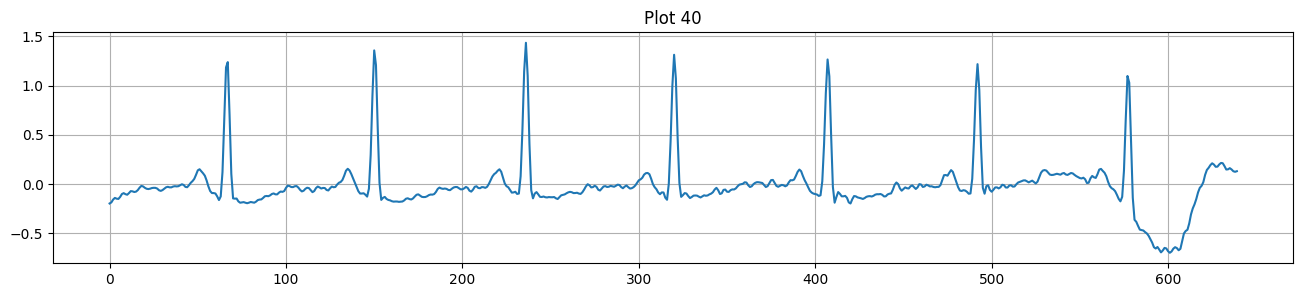

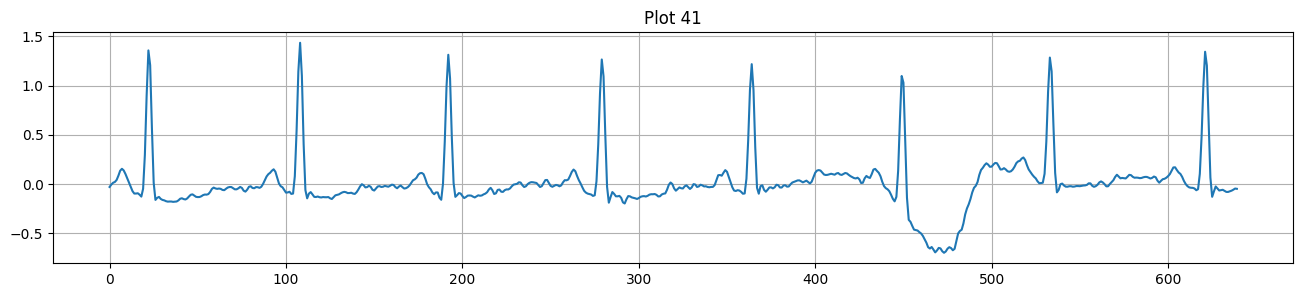

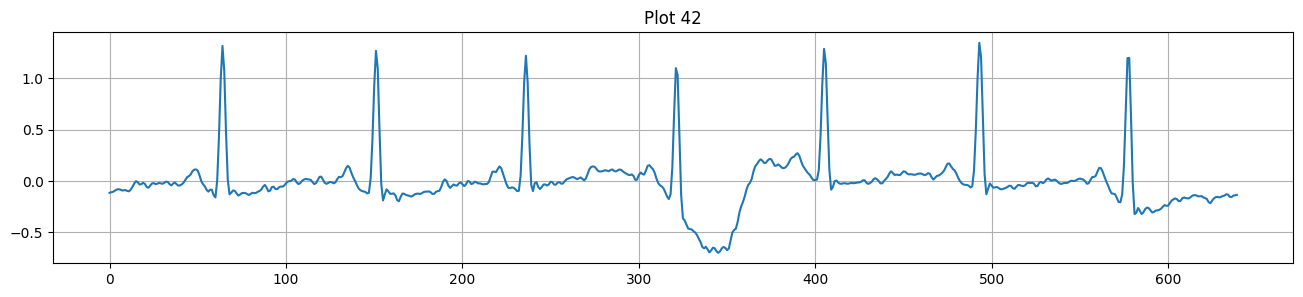

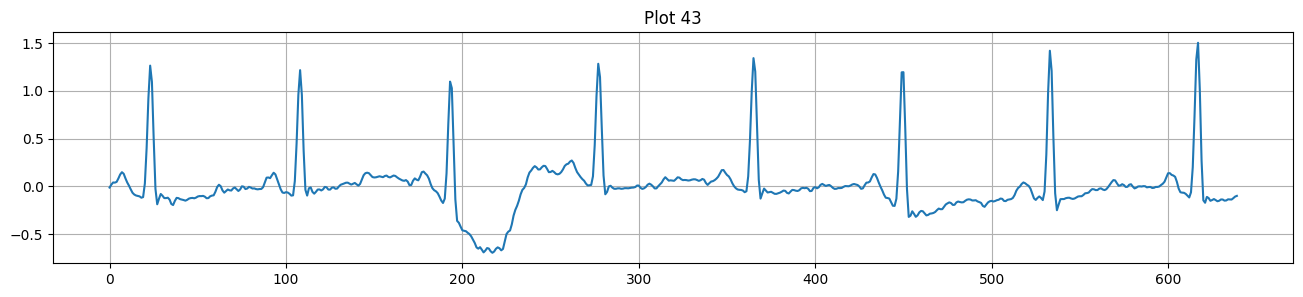

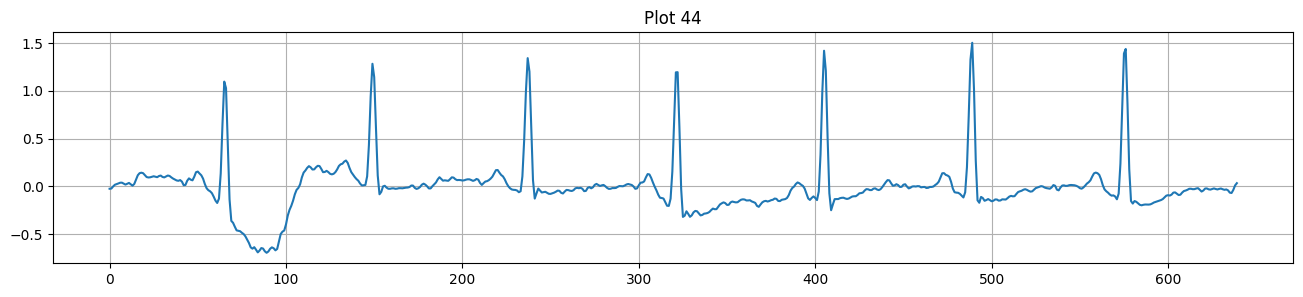

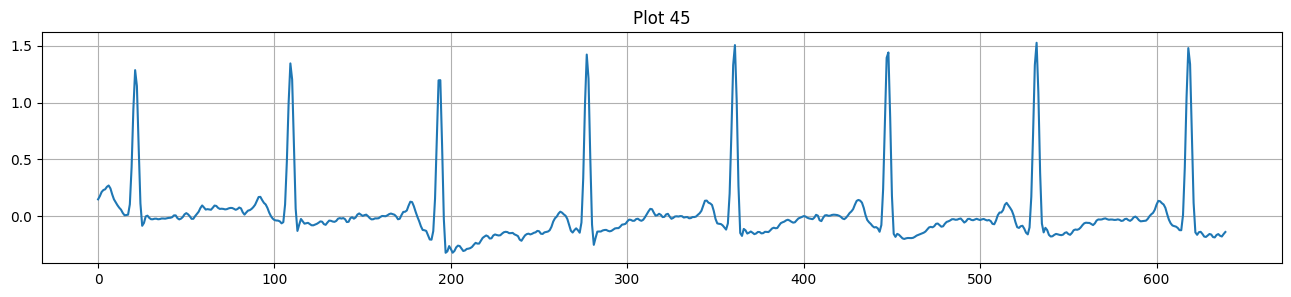

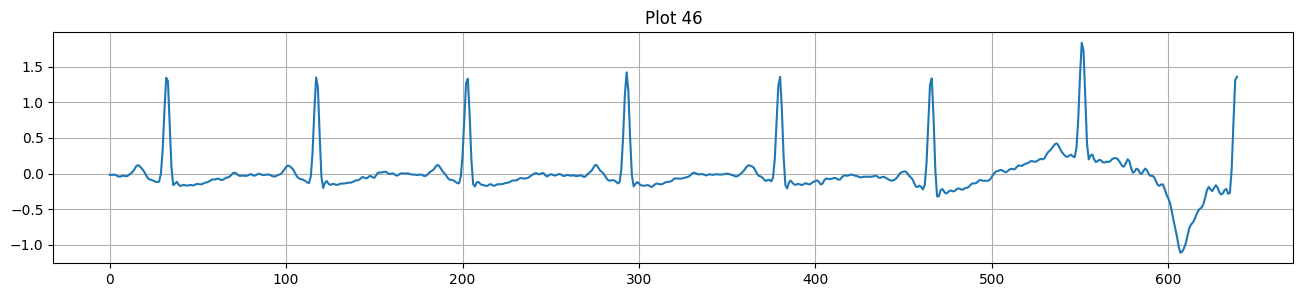

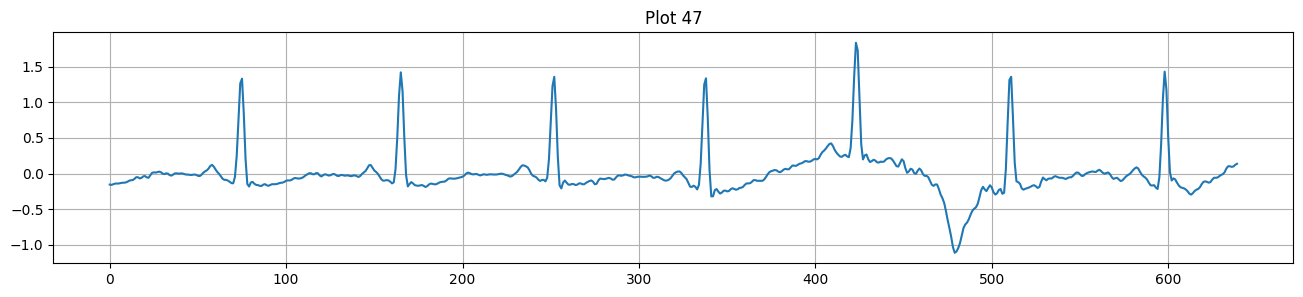

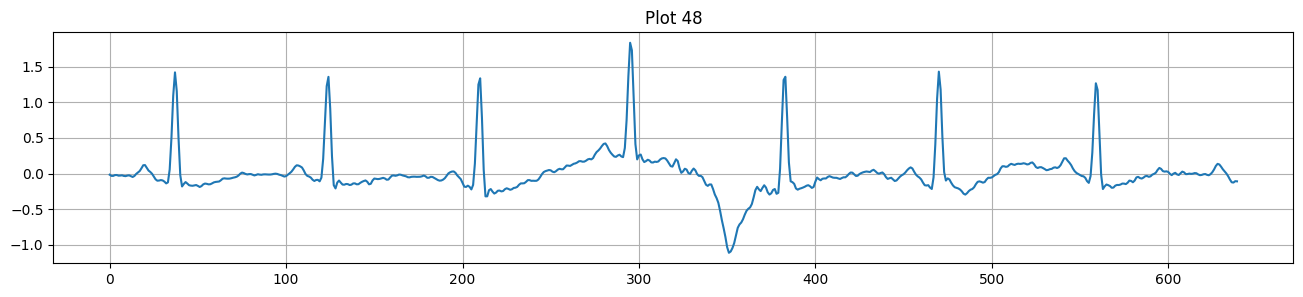

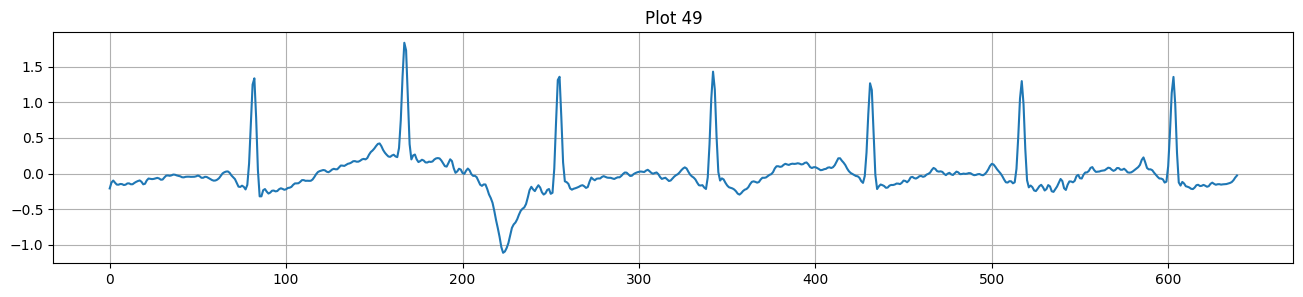

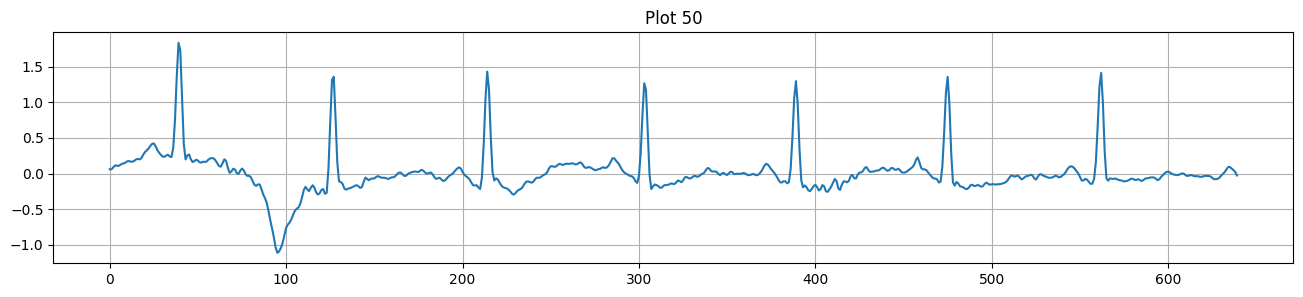

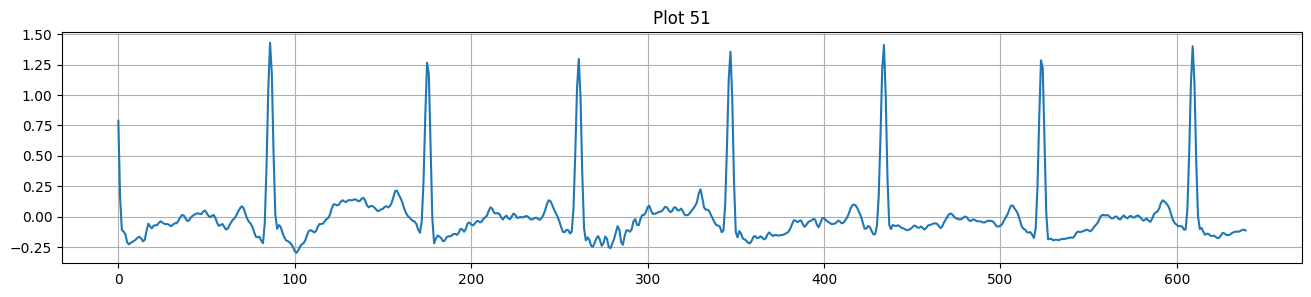

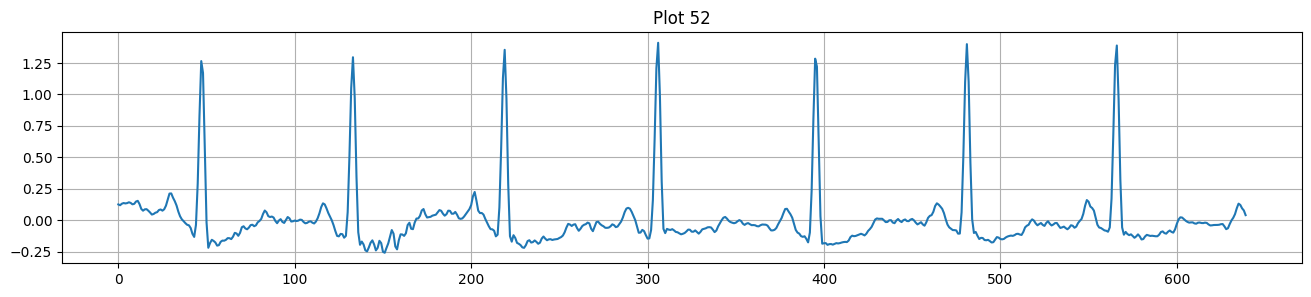

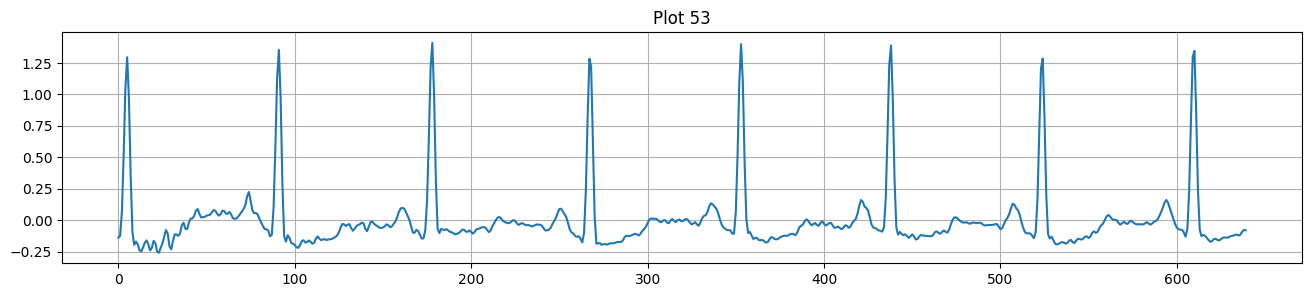

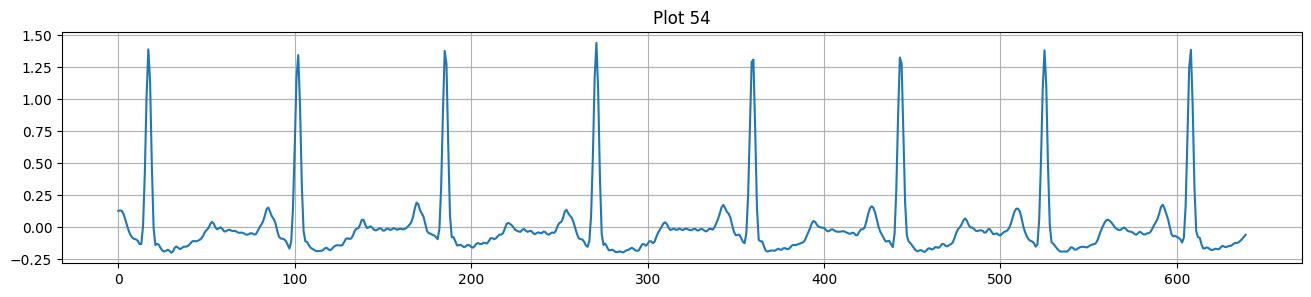

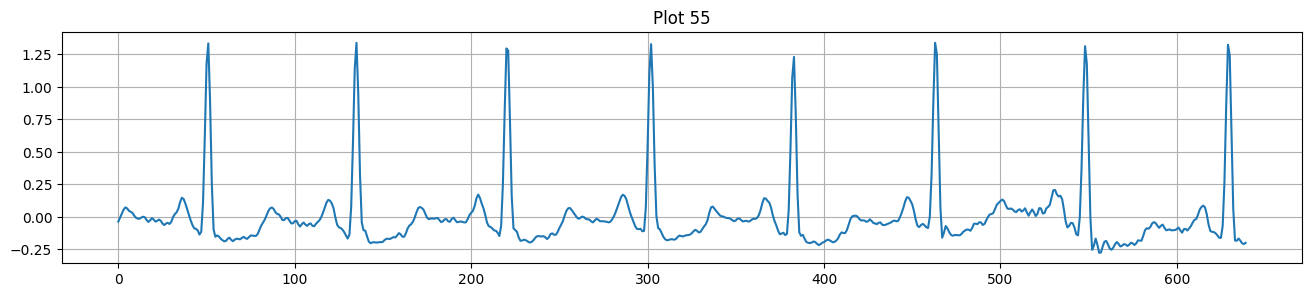

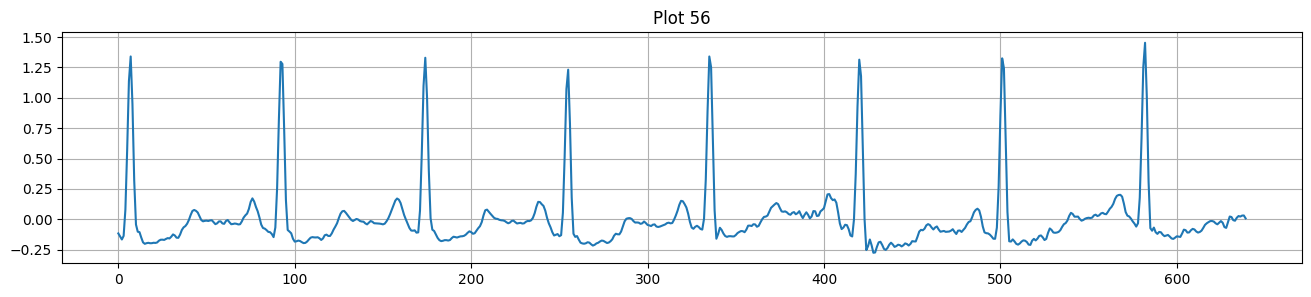

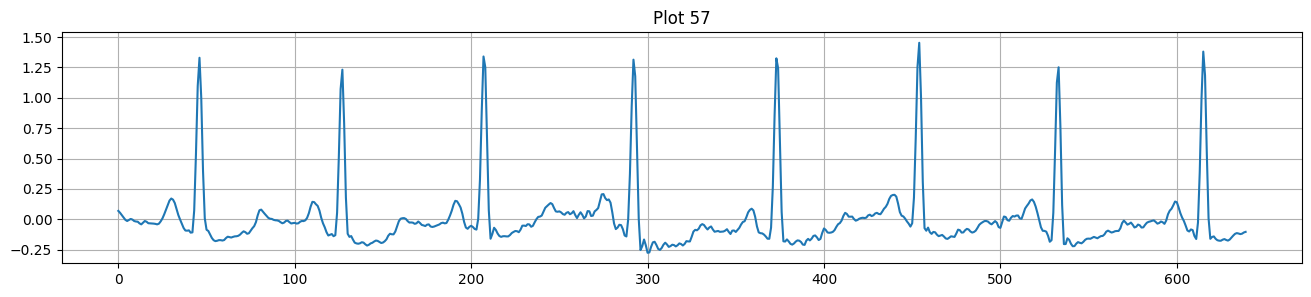

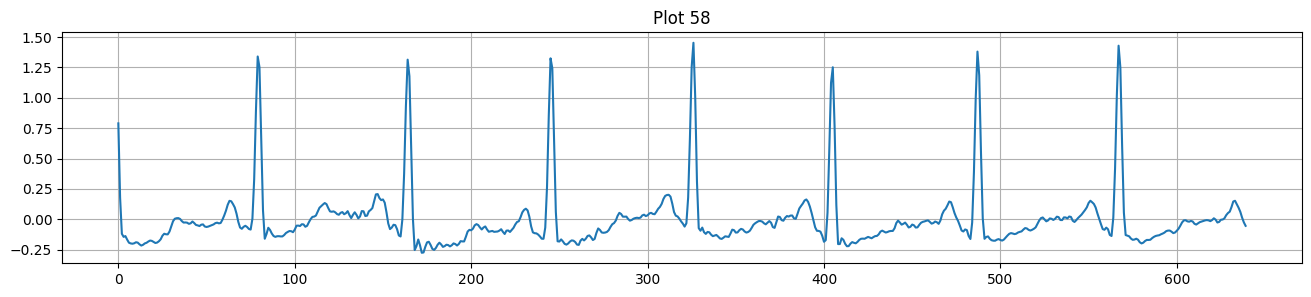

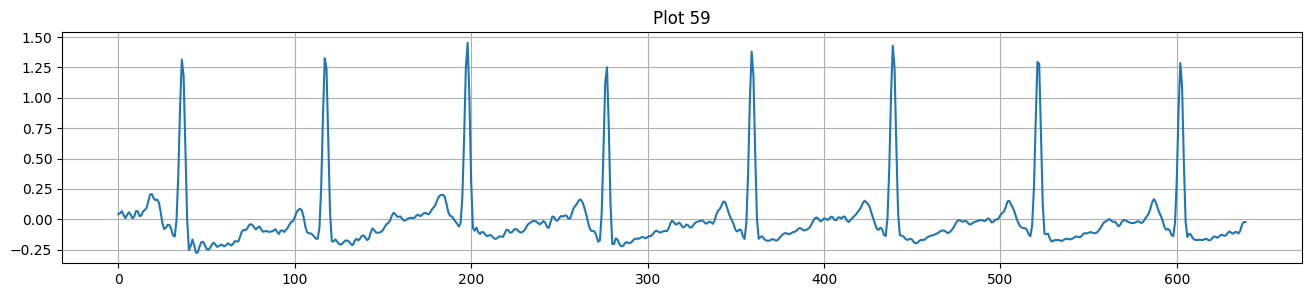

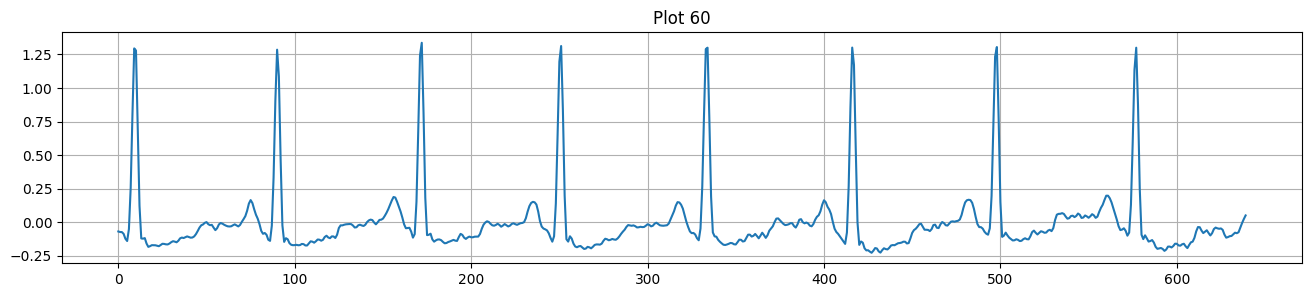

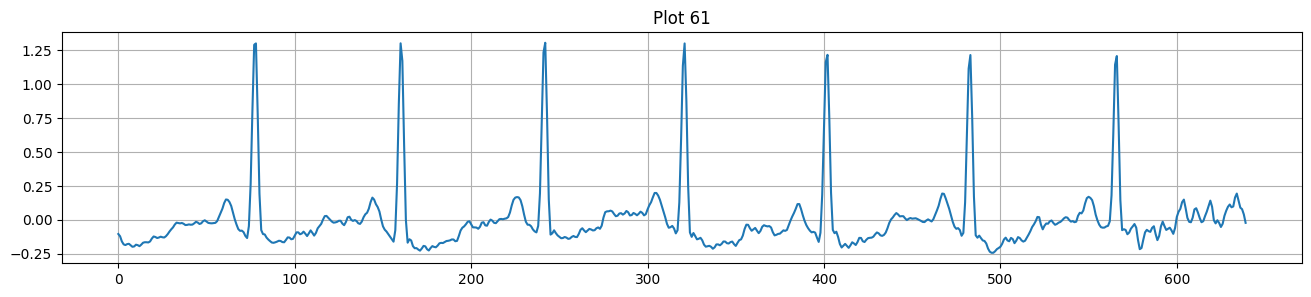

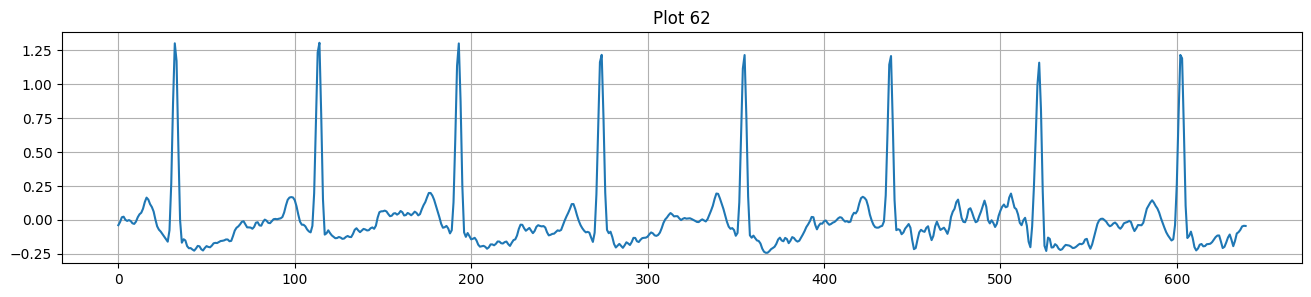

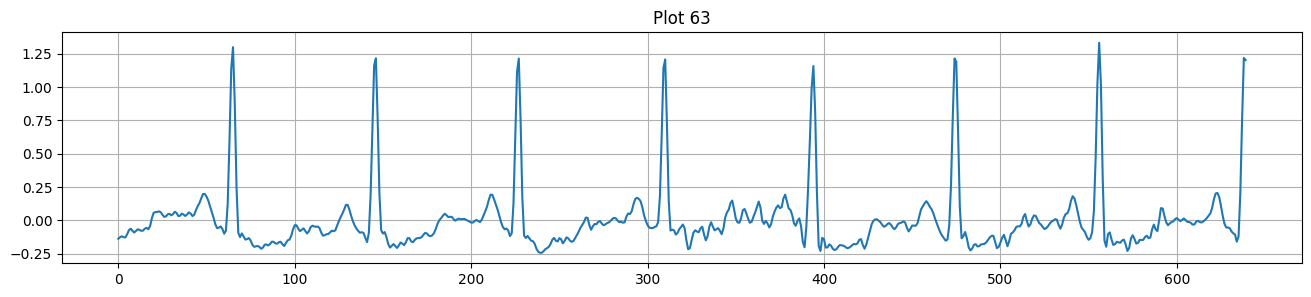

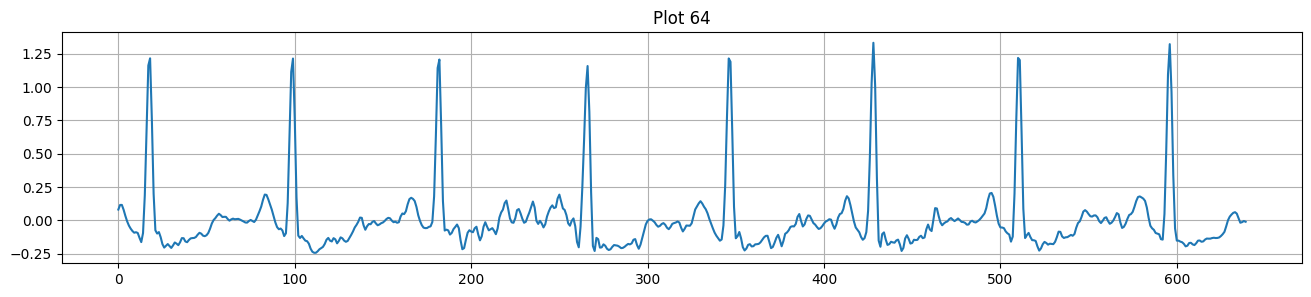

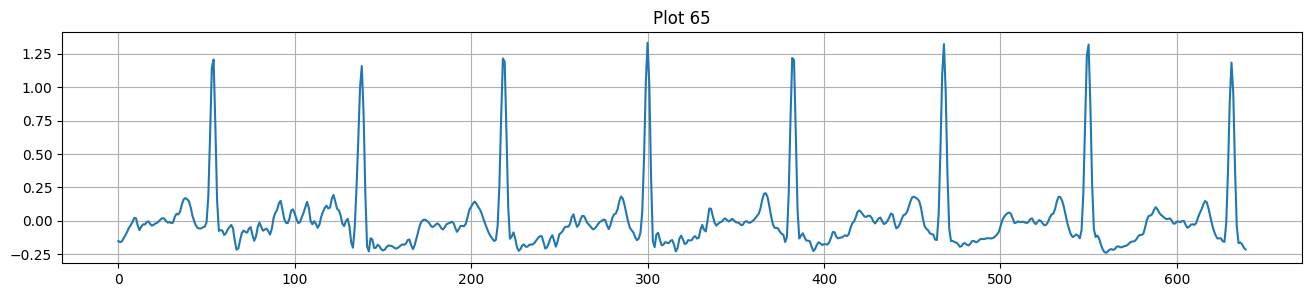

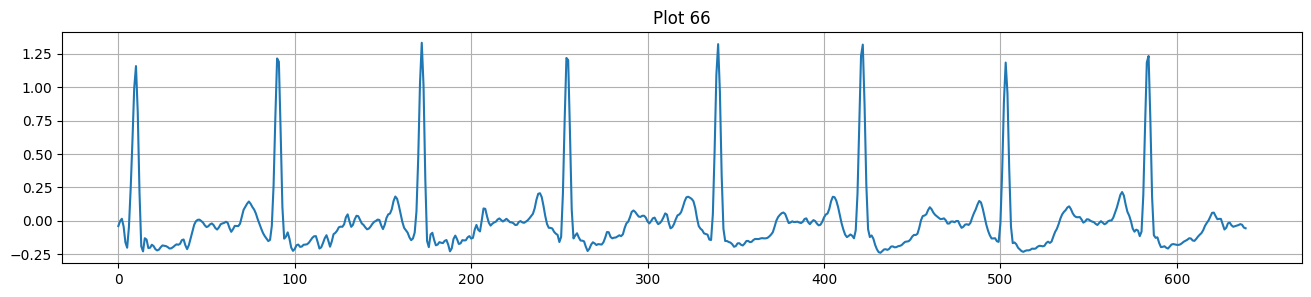

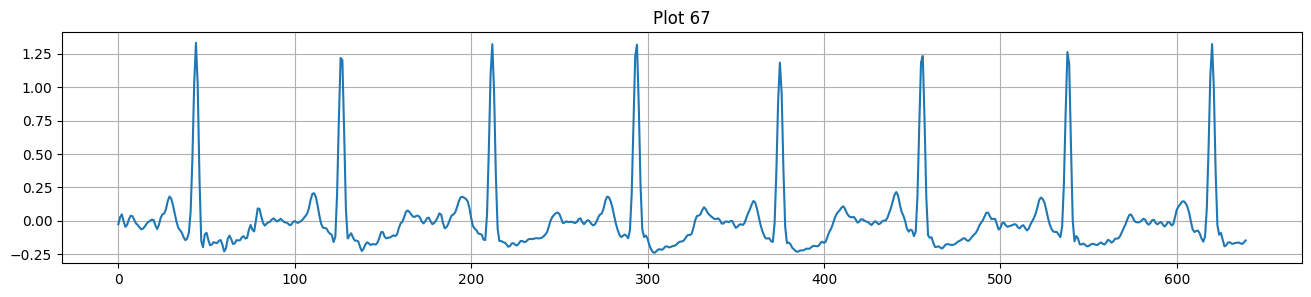

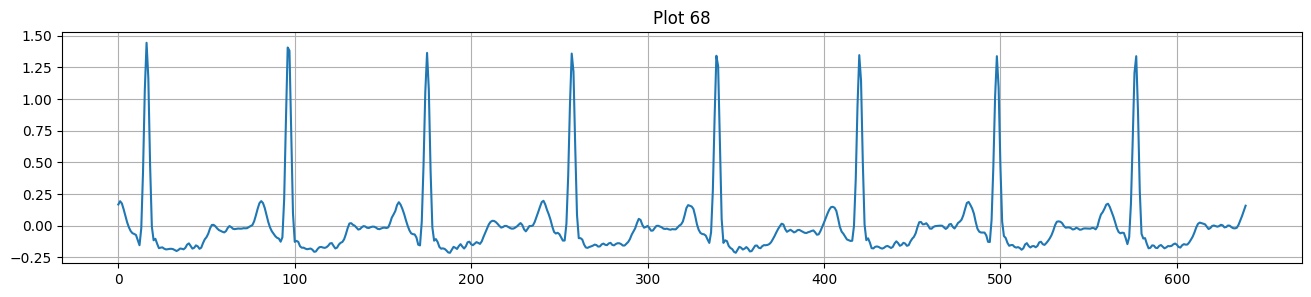

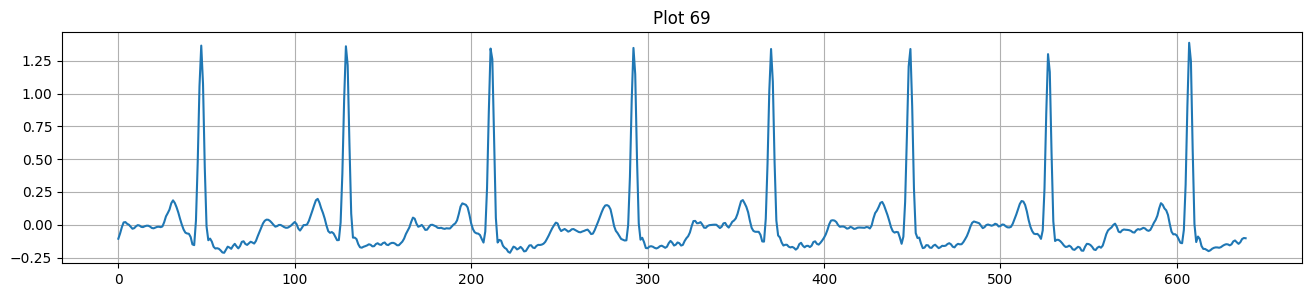

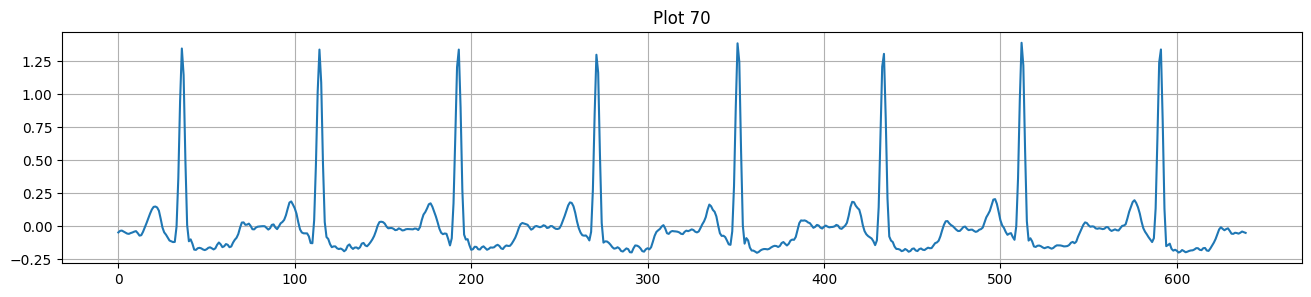

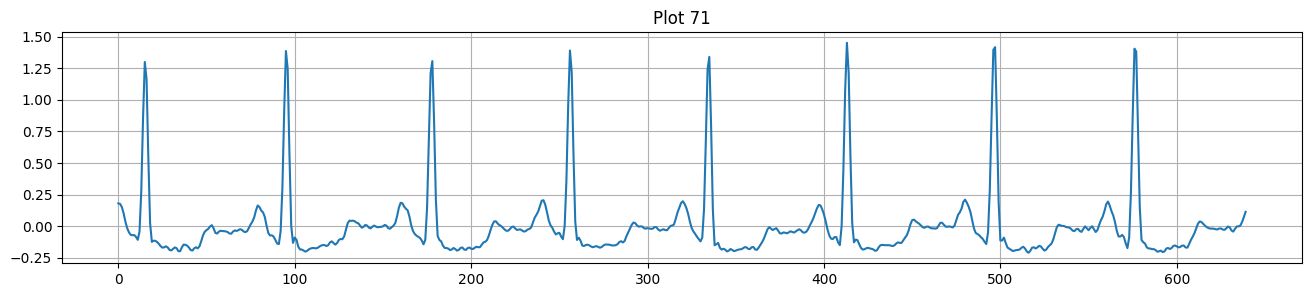

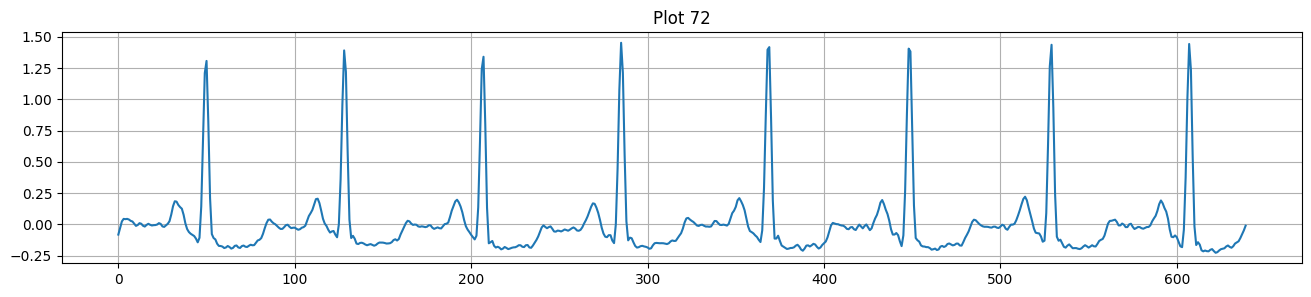

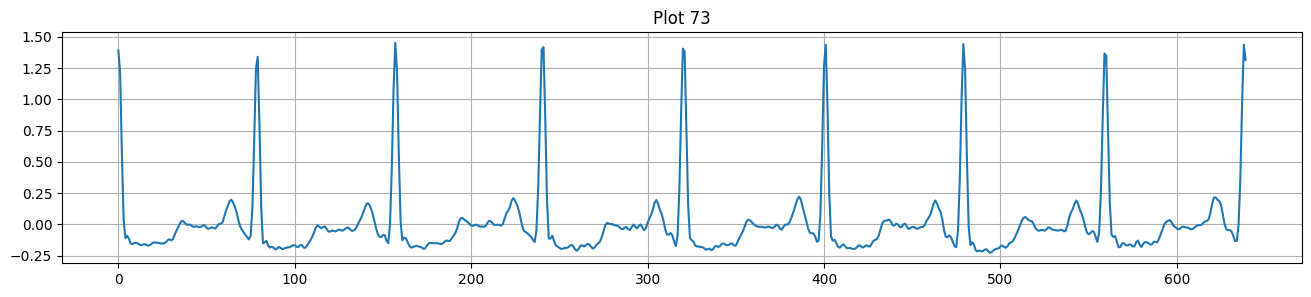

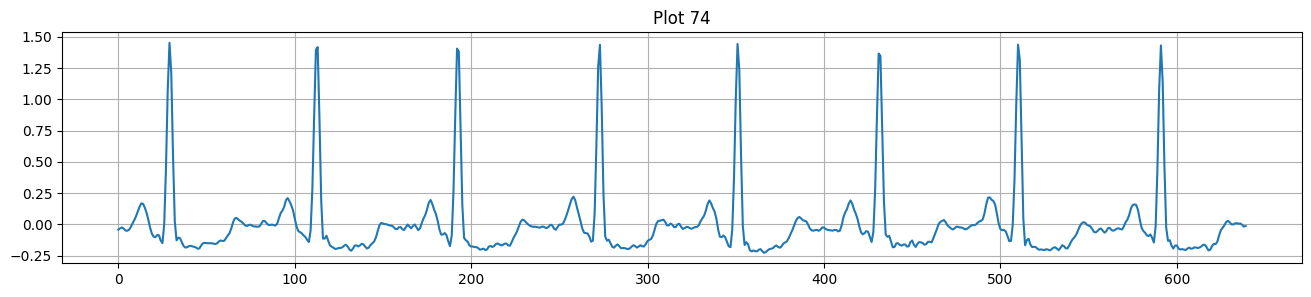

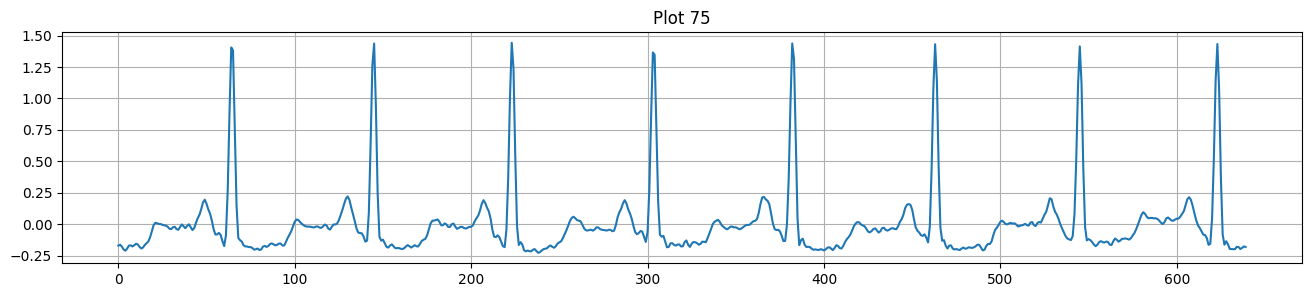

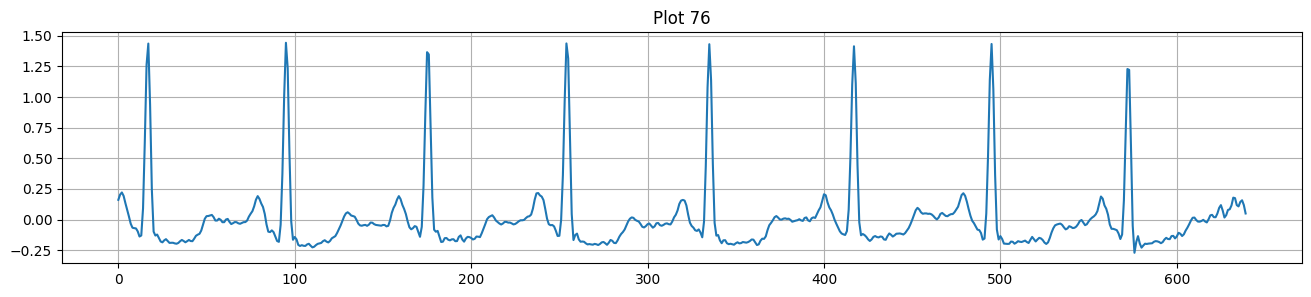

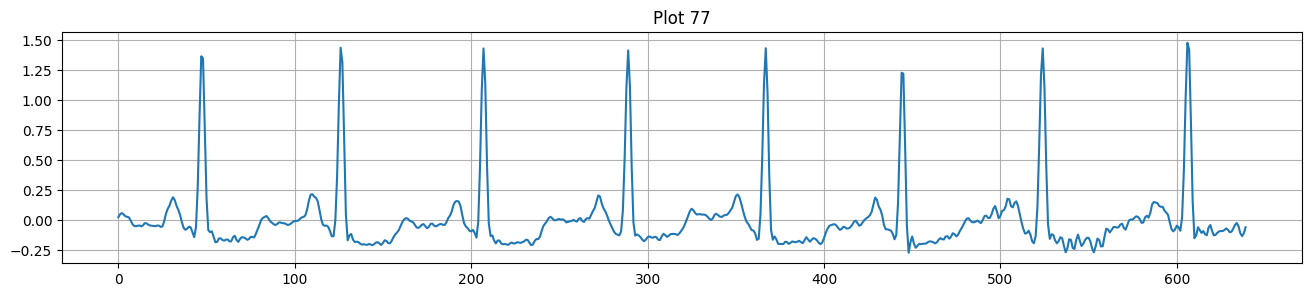

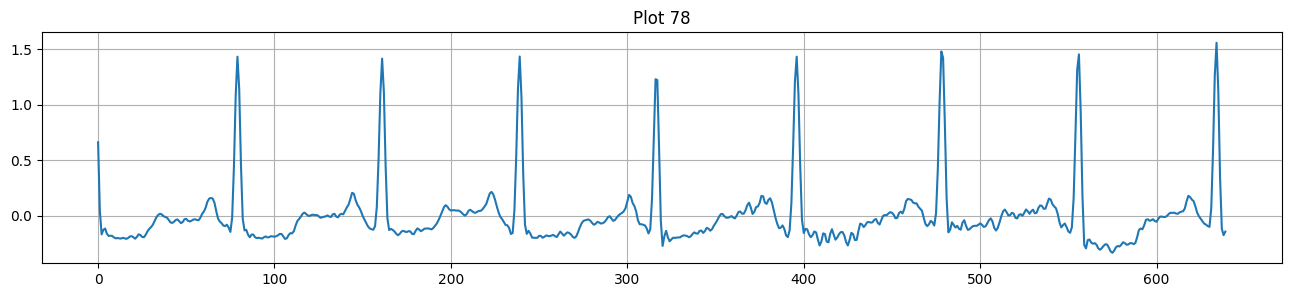

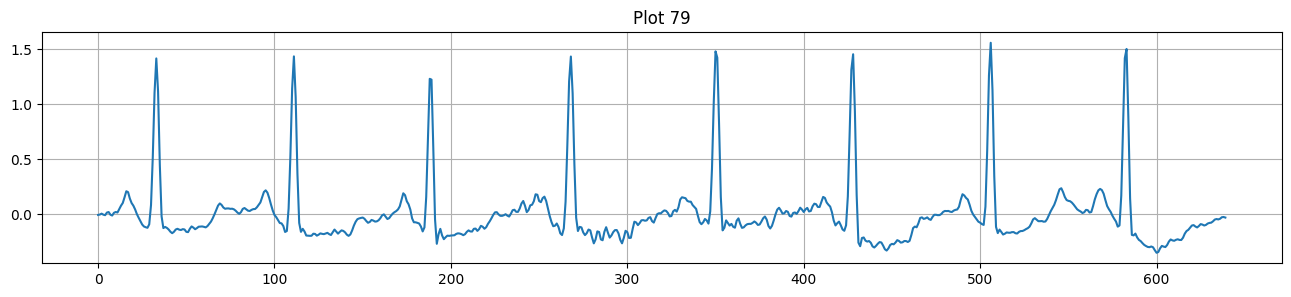

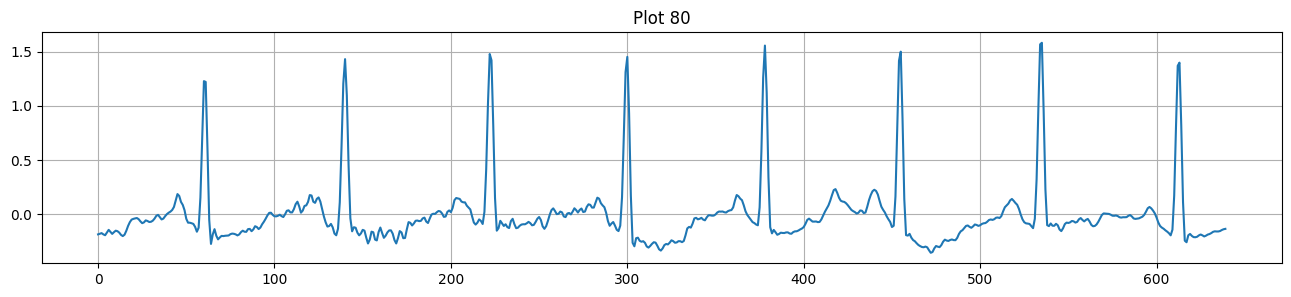

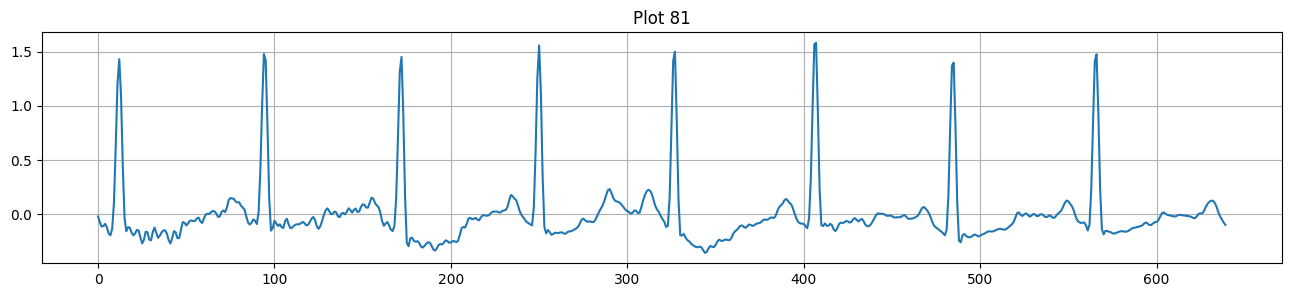

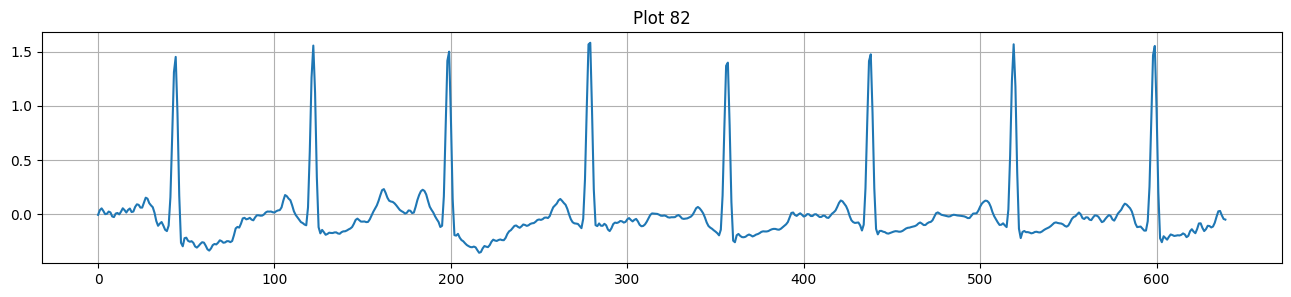

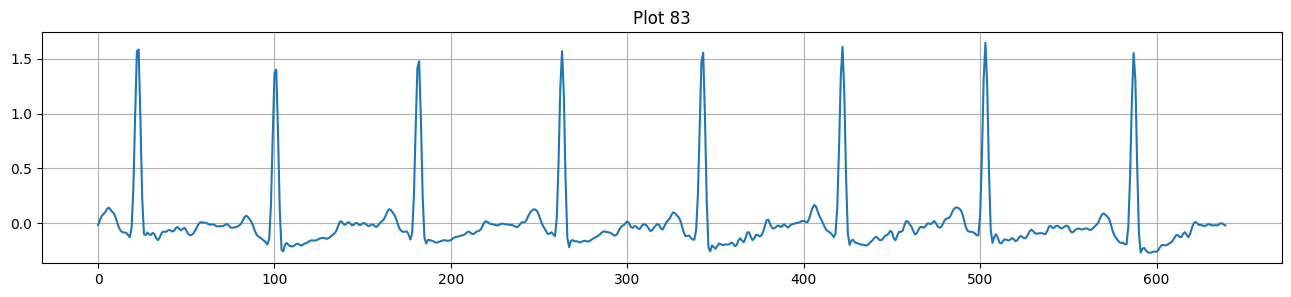

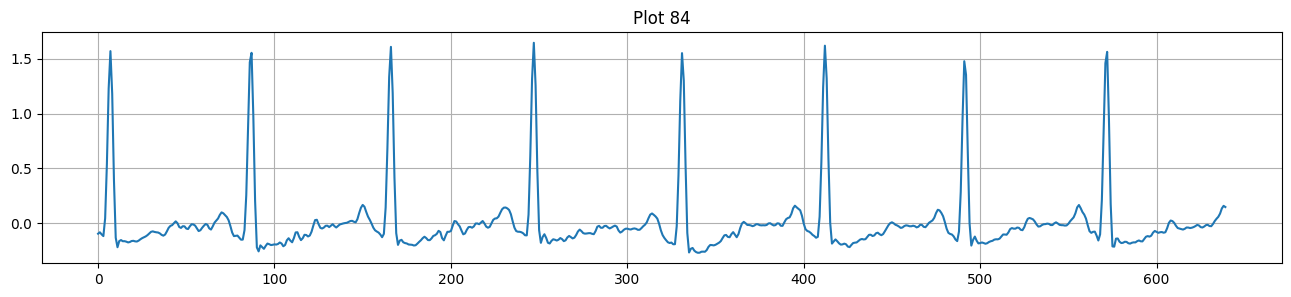

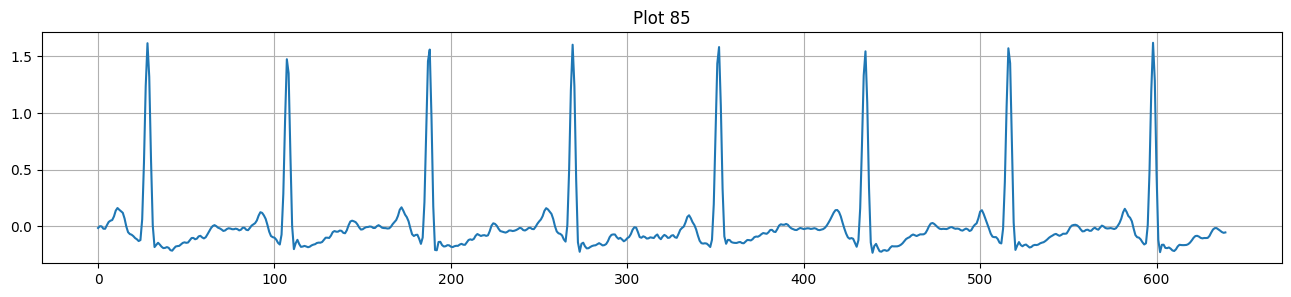

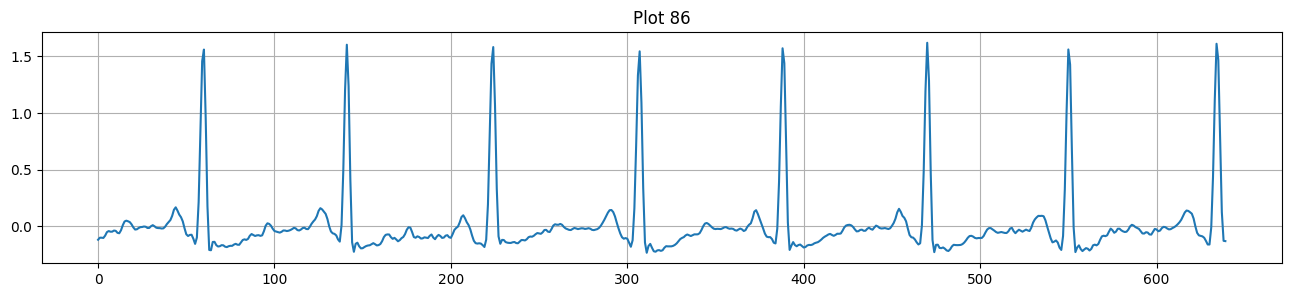

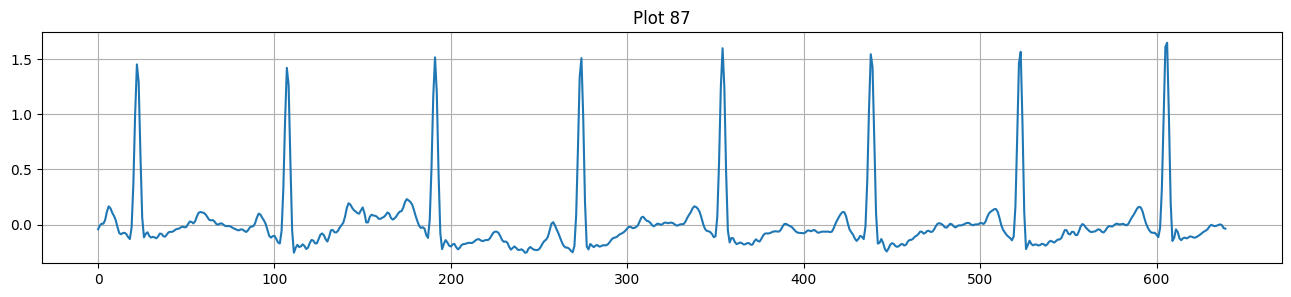

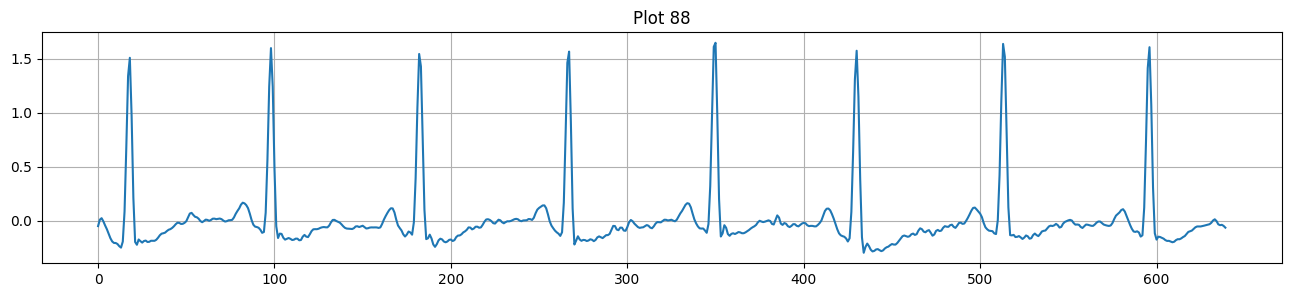

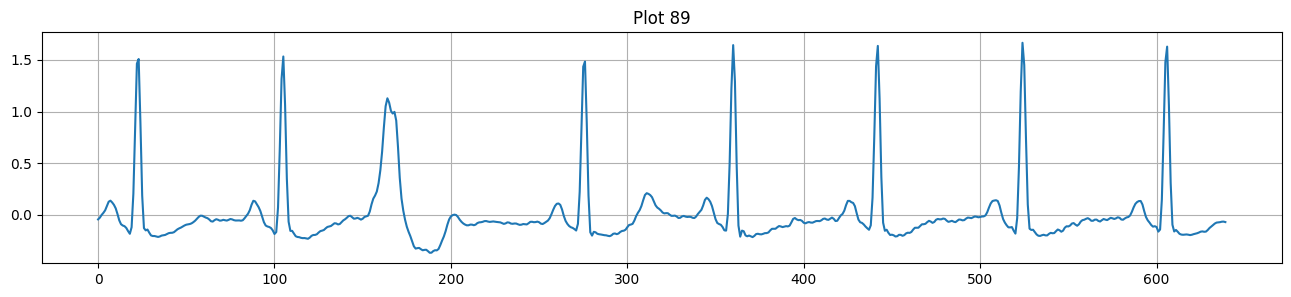

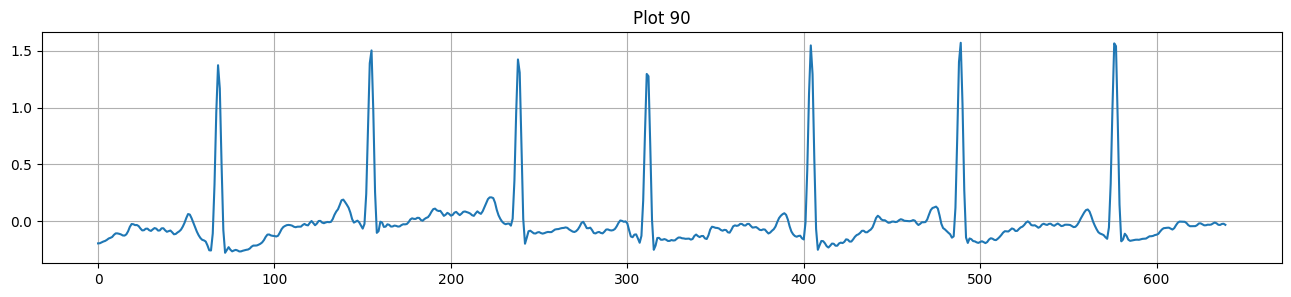

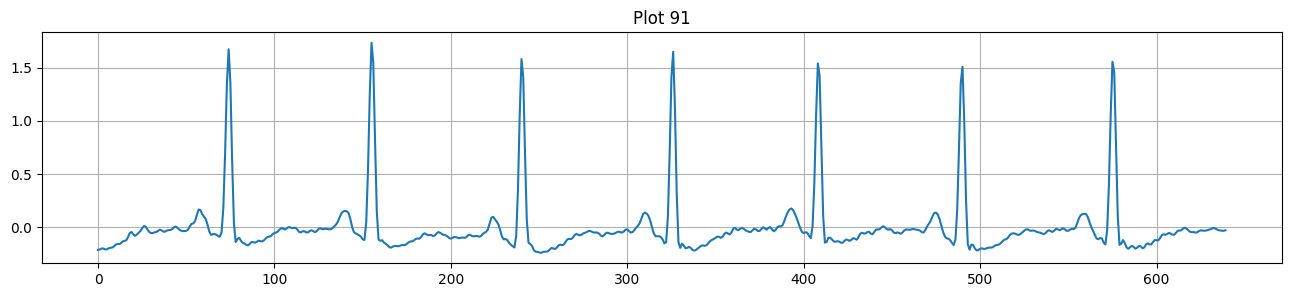

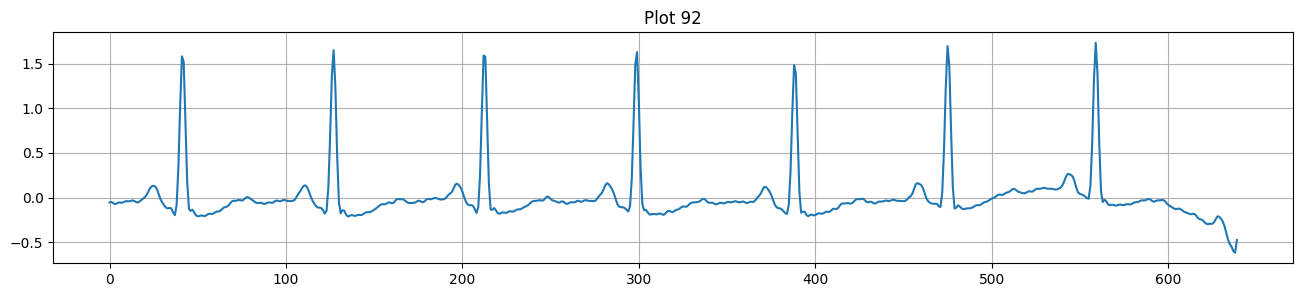

In [439]:
for i, data in enumerate(anomaly_window):
    # Creates a new figure for each iteration
    plt.figure(figsize=(16, 3))
    plt.plot(data)
    plt.title(f'Plot {i+1}')
    plt.grid()

plt.show() # Displays all the figures created in the loop
